In [107]:
%%html

<!-- 
hack to inject CSS in jupyterlab. 

Please RUN this cell before read the document
-->

<style>
    .alert-success {
        background-color: #dff0d8;
        border-color: #d6e9c6;
        color: #3c763d;
    }
    .alert {
        padding: 15px;
        margin-bottom: 18px;
        border: 1px solid transparent;
        border-radius: 2px;
    }
    .alert-info {
        background-color: #d9edf7;
        border-color: #bce8f1;
        color: #31708f;
    }
    .alert-warning {
        background-color: #fcf8e3;
        border-color: #faebcc;
        color: #8a6d3b;
    }
    .badge {
        display: inline-block;
        min-width: 10px;
        padding: 3px 7px;
        font-size: 12px;
        font-weight: bold;
        color: #fff;
        line-height: 1;
        vertical-align: middle;
        white-space: nowrap;
        text-align: center;
        background-color: #777777;
        border-radius: 10px;
    }
</style>

In [0]:
import seaborn

# PGDS Rumos - Programação em Python 
### Trabalho prático individual

Data limite de entrega: 3 de Agosto de 2019 às 23:59

---



# Parte 2

A segunda parte do trabalho de Pandas pretende cimentar os conhecimentos de pandas terminando a pipeline de DS.

A estrutura deste notebook e dos módulos de python já se encontra definida. Apenas terão de:

1. completar funções ou parte de código;
2. implementar a totalidade do código numa **única** célula de forma a responder a uma pergunta.

**Nota**: se vos for mais conveniente poderão alterar a estrutura dos módulos e / ou notebook. Se assim o quiserem, por favor, adicionem comentários esclarecedores relativos a cada parte de forma a eu não cometer erros na avaliação.

<p>
  <div class="alert alert-success">
    Todas as perguntas estarão assinaladas com este fundo verde.
  </div>
</p>

<p>
  <div class="alert alert-info">
    Notem que durante o notebook irão encontrar o comando <a href="https://wiki.python.org/moin/UsingAssertionsEffectively">assert</a> várias vezes. Este comando permite verificar se duas expressões têm o mesmo valor. Irei usá-lo para confirmar que certos valores estão correctos. <span class="badge">Caso algum dê erro, venham falar comigo.</span>
  </div>
</p>

O índice da segunda parte é o seguinte:

**1. Continuar data understanding** <br>
- 1.1 Dados de voos
- 1.2 Análise temporal
- 1.3 Considerando informação de contexto

**2. Gerar dataset histórico, de treino e de teste** <br>
- 2.1 Motivação
- 2.2 Construção dos datasets

**3. Feature Engineering** <br>
- 3.1 Usando dados históricos
- 3.2 Novos campos temporais
- 3.3 Risky features e OHE
- 3.4 Normalizar colunas
- 3.5 Outras colunas
- 3.6 Remover colunas desnecessárias

**4. Construir regressão logística** <br>
- 4.1 Treino do modelo
- 4.2 Construir matriz de confusão
- 4.3 Avaliar performance do modelo

___

In [0]:
def read_flights_data(path):
    """
    Reads flights dataset
    
    I'm specifiying different types for each column due to memory consumption
    
    Parameters:
    ----------
    path : string
        flights dataset location
    """
    import pandas as pd
    import csv
    return pd.read_csv(path, 
                     sep=',',
                     quoting=csv.QUOTE_NONE,
                     dtype={'air_system_delay': 'float32',
                            'air_time': 'float32',
                            'airline': 'category',
                            'airline_delay': 'float32',
                            'arrival_delay': 'float32',
                            'arrival_time': 'float32',
                            'cancellation_reason': 'category',
                            'cancelled': 'bool',
                            'day': 'int32',
                            'day_of_week': 'int32',
                            'departure_delay': 'float32',
                            'departure_time': 'float32',
                            'destination_airport': 'object',
                            'distance': 'int32',
                            'diverted': 'bool',
                            'elapsed_time': 'float32',
                            'flight_number': 'int32',
                            'late_aircraft_delay': 'float32',
                            'month': 'int32',
                            'origin_airport': 'object',
                            'scheduled_arrival': 'float32',
                            'scheduled_departure': 'float32',
                            'scheduled_time': 'float32',
                            'security_delay': 'float32',
                            'tail_number': 'object',
                            'taxi_in': 'float32',
                            'taxi_out': 'float32',
                            'weather_delay': 'float32',
                            'wheels_off': 'float32',
                            'wheels_on': 'float32',
                            'year': 'int32'}
    )



Vamos começar por carregar todas as dependências que podemos vir a usar. 

In [110]:
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# https://plot.ly/python/offline/
import plotly.offline as py

from os import listdir
from os.path import isfile, join
from sklearn import linear_model
from pandas import Series

# inline matplotlib plots
%matplotlib inline
# inline plotly plots
py.init_notebook_mode(connected=True)

# all pandas prints will have this format
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_rows', 200)

# Reload all modules (except those excluded by %aimport) before executing the Python code typed.
# http://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
plt.rcParams['figure.figsize'] = 12, 8  # default image size

___
### 1. Continuar data understanding
___

Por ser um notebook diferente, temos de voltar a carregar os datasets em memória.

In [112]:
import os
path = join(os.getcwd(), '')

#airlines = pd.read_csv(join(path, 'airlines.csv'))
#airports = pd.read_csv(join(path, 'airports.csv'))
#flights = read_flights_data(join(path, 'flights_until_june.csv'))

airlines = pd.read_csv('https://gitlab.com/elsousa/pgds-rumos/raw/master/airlines.csv')
airports = pd.read_csv('https://gitlab.com/elsousa/pgds-rumos/raw/master/airports.csv')
flights = pd.read_csv('https://gitlab.com/elsousa/pgds-rumos/raw/master/flights_until_june.csv')


# confirm number of rows and columns per dataset
assert airlines.shape == (14, 2)
assert airports.shape == (322, 7)
assert flights.shape == (2889512, 31)
print('Airlines:', airlines.shape)
print('Airports:', airports.shape)
print(' Flights:', flights.shape)

Airlines: (14, 2)
Airports: (322, 7)
 Flights: (2889512, 31)


Antes de começar o DU vamos remover algumas colunas que não serão usadas.

In [0]:
columns_to_remove = 'flight_number day_of_week tail_number departure_time taxi_out wheels_off wheels_on taxi_in scheduled_arrival arrival_time diverted'.split()

flights.drop(columns_to_remove, inplace=True, axis=1)

Na primeira parte do trabalho definimos as colunas `date` e `is_delayed`. Na próxima célula cole o código necessário para as criar, pois estas serão usadas ao longo deste notebook.

<span class="badge">Nota:</span> Se não conseguiu definir alguma destas colunas entre em contacto com o formador.

In [114]:
flights['is_delayed'] = flights.arrival_delay >= 15
flights.head()

kk = flights[['year','month','day']] 

#to_datetime agrega valores de cada uma das series ano/mes/dia
flights['date'] = pd.to_datetime(kk)

flights['date'].head(10)
flights.columns

Index(['year', 'month', 'day', 'airline', 'origin_airport',
       'destination_airport', 'scheduled_departure', 'departure_delay',
       'scheduled_time', 'elapsed_time', 'air_time', 'distance',
       'arrival_delay', 'cancelled', 'cancellation_reason', 'air_system_delay',
       'security_delay', 'airline_delay', 'late_aircraft_delay',
       'weather_delay', 'is_delayed', 'date'],
      dtype='object')

#### 1.1 Dados de voos

Como complemento ao data understanding (DU) realizado na primeira parte do trabalho, vamos começar por coletar insights sobre o atraso do voos.

Como se observou na primeira parte do trabalho, os atrasos variam imenso de companhia aéra para companhia aérea. Assim sendo, vamos analisar um pouco mais esta questão de voos atrasados. Afinal, é isso que queremos prever com a regressão logística.
<br><br>
Se repararem, para os voos com atraso, temos detalhado nas colunas `airline_delay`, `late_aircraft_delay`, `air_system_delay`, `security_delay` e `weather_delay` o tempo de atraso associado com cada uma deste motivos.
<br><br>
<div class="alert alert-success">
Q.1<br>
    Assim, vamos começar por analisar a distribuição dos motivos de atraso por mês - <b>apenas para os voos com atraso</b>. 
    <br><br>
    Portanto, a ideia é, para cada mês, obter a percentagem dos atrasos que cada motivo de atraso representa. Assim, construa o dataframe <code>delays</code> com esta informação mensal.
    <br><br>
    A variável <code>total_delay</code> tem, para cada mês, a soma de todos os atrasos. 
</div>

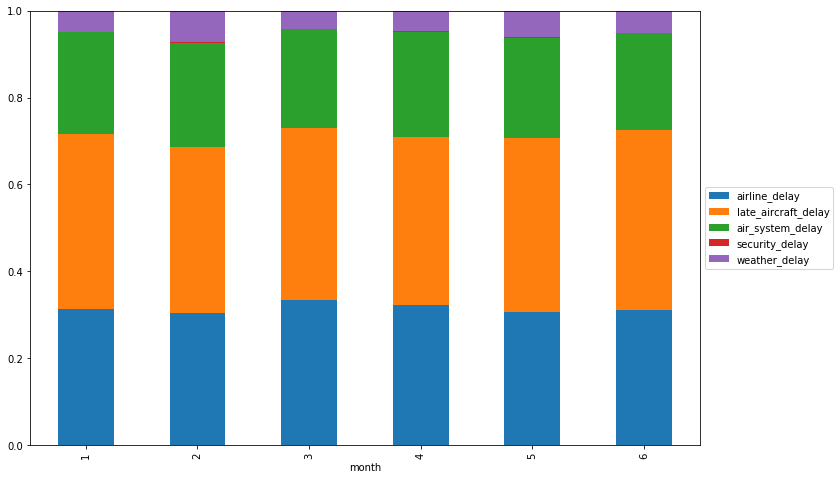

In [115]:
from pandas import DataFrame
import numpy as np

# delays dataframe should have this format
#
#        airline_delay  late_aircraft_delay  air_system_delay  security_delay  weather_delay 
# month                                                                                       
# 1              0.314                0.401             0.235           0.001          0.048  
# 2              0.304                0.383             0.239           0.001          0.073  
# 3              0.334                0.396             0.226           0.001          0.042  
# 4              0.323                0.387             0.242           0.001          0.048  
# 5              0.307                0.400             0.231           0.001          0.062  
# 6              0.312                0.415             0.221           0.001          0.052 

columns = 'month airline_delay late_aircraft_delay air_system_delay security_delay weather_delay'.split()

#new DF
delays = flights[columns][flights.is_delayed == True].groupby('month').agg('sum')
delays.head(100)

total_delay = delays.sum(axis=1)
total_delay

for c in delays.columns:
  delays[c] /= total_delay
  
delays


delays.plot.bar(stacked=True, ylim=(0,1)).legend(loc='center left', bbox_to_anchor=(1, 0.5))


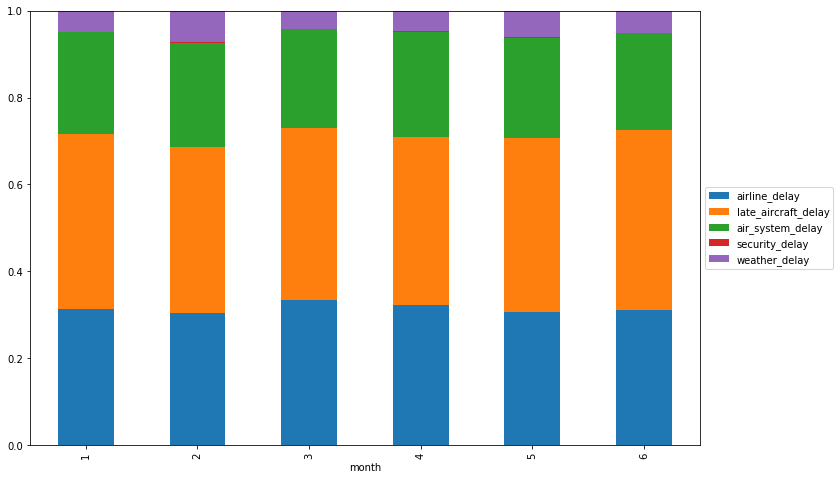

In [116]:
# the bar plot should be similar to this plot

from IPython.display import display, HTML
display(HTML('''
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA0gAAAHgCAYAAACfN01xAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvqOYd8AAAIABJREFUeJzt3XtcV1W+//H3B1AUJbyAdw0VuXxBmYIoyxlNbcoy05ymzElLzbJxus9jOk3jr9Pc8jR1ysd0USsrrXFmcibNmunoqczpNmKKCkJqopaa4gXxhgLr94cLDxEIKfAVfT0fDx99995r7/2B9Uh8s9Ze25xzAgAAAABIIcEuAAAAAABOFwQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAr8aAZGYvmtkOM1tTzXEzs2lmtt7MVpnZ+XVfJgAAAADUv9qMIL0k6YoTHB8iqZf/M1HSs6deFgAAAAA0vBoDknPuA0m7T9DkGkmvuGM+kdTKzDrWVYEAAAAA0FDq4hmkzpK2VNj+0u8DAAAAgEYlrCFvZmYTdWwanlq0aJGWmJjYYPfesamowe4VDO3OjQx2CfXqTO4/+q5xo/8atzO5/+i7xo3+q1vLly8vcM7FNOhN0WjVRUD6SlLXCttd/L5vcc7NkDRDktLT011mZmYd3L52nr793Qa7VzD89LmBwS6hXp3J/UffNW70X+N2Jvcffde40X91y8w2NegN0ajVxRS7BZLG+NXsLpJU6JzbVgfXBQAAAIAGVeMIkpn9SdIASdFm9qWk/yepiSQ5556T9LakKyWtl3RQ0i31VSwAAAAA1KcaA5JzblQNx52kn9ZZRQAAAAAQJHUxxQ4AAAAAzggEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAFxbsAgCc2Z7re1ewS6hXP9XqYJcAAADqECNIAAAAAOAxggQAqNbA938a7BLq2dpgFwAAOM2cNQGJaT4A8N39+D/O7B8T/M0JAKjszP7JBwAA0Ajxi10geHgGCQAAAAA8AhIAAAAAeAQkAAAAAPB4BgkAgDMQKxACwMkhIAEAcAZiBUIAODlMsQMAAAAAj4AEAAAAAB4BCQAAAAC8M3uCMs4YZ/bDxjxoDAAAcLogIKFROJMfNuZBYwAAgNMHU+wAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBXq4BkZleYWZ6ZrTezB6o43s3M3jOzFWa2ysyurPtSAQAAAKB+1RiQzCxU0tOShkgKSBplZoFKzR6S9Bfn3HmSbpD0TF0XCgAAAAD1rTYjSBmS1jvnvnDOHZE0V9I1ldo4Sef4z1GSttZdiQAAAADQMMJq0aazpC0Vtr+UdGGlNg9L+h8z+5mkFpIG10l1AAAAANCA6mqRhlGSXnLOdZF0paTZZvata5vZRDPLNLPMnTt31tGtAQAAAKBu1CYgfSWpa4XtLn5fReMl/UWSnHMfS2omKbryhZxzM5xz6c659JiYmJOrGAAAAADqSW0C0jJJvcysu5k11bFFGBZUarNZ0iBJMrMkHQtIDBEBAAAAaFRqDEjOuRJJkyW9I2mtjq1Wl21mj5jZMN/sPkm3mlmWpD9Jutk55+qraAAAAACoD7VZpEHOubclvV1p35QKn3MkXVK3pQEAAABAw6qrRRoAAAAAoNEjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMAjIAEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPAISAAAAAHgEJAAAAADwCEgAAAAA4BGQAAAAAMALC3YBAM5sqzduDnYJAAAAtcYIEgAAAAB4jCABAACcZhh9B4KHESQAAAAA8AhIAAAAAOARkAAAAADAO2ueQWIuLwAAAICaMIIEAAAAAB4BCQAAAAC8s2aKHQDgu2N6MgDgbENAAgDgDES4BYCTwxQ7AAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeLwoFo0CLzwEAABAQ2AECQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAC8WgUkM7vCzPLMbL2ZPVBNmx+bWY6ZZZvZa3VbJgAAAADUv7CaGphZqKSnJV0m6UtJy8xsgXMup0KbXpL+Q9Ilzrk9ZtauvgoGAAAAgPpSmxGkDEnrnXNfOOeOSJor6ZpKbW6V9LRzbo8kOed21G2ZAAAAAFD/ahOQOkvaUmH7S7+vonhJ8Wb2oZl9YmZXVHUhM5toZplmlrlz586TqxgAAAAA6kldLdIQJqmXpAGSRkmaaWatKjdyzs1wzqU759JjYmLq6NYAAAAAUDdqE5C+ktS1wnYXv6+iLyUtcM4ddc5tlPS5jgUmAAAAAGg0alykQdIySb3MrLuOBaMbJN1Yqc0bOjZyNMvMonVsyt0XdVkoAAAAUFeWL1/eLiws7HlJKeLVN2eTMklrSkpKJqSlpVW5bkKNAck5V2JmkyW9IylU0ovOuWwze0RSpnNugT/2QzPLkVQq6efOuV119mUAAAAAdSgsLOz5Dh06JMXExOwJCQlxwa4HDaOsrMx27twZ2L59+/OShlXVpjYjSHLOvS3p7Ur7plT47CTd6/8AAAAAp7sUwtHZJyQkxMXExBRu3749pdo2DVkQAAAAcJoIIRydnXy/V5uDCEgAAAAA4NVqih0AAABwJot94K20urxe/qNXLT+Z8/r37x83b968jdHR0aWVj3Xu3Ll3Zmbm2o4dO5acd955iStWrMg99Uq/LS8vr+nQoUN7rVu3LvtU2jRWBCQAAADgNLFkyZL1lfeVlZXp2CP//6e+whGYYgcAAAAExeDBg3smJycnxcXFJf/hD3+Ilo6NEm3bti0sLy+vaWxsbMqIESNi4+Pjkzds2NC04rkRERHnSdLChQsjMzIyEq644ooe3bt3Tx42bFj3srIySdLSpUsjLrjggoTk5OSkfv369dq0aVOT6mpZunRpREJCQiAhISHwxBNPtCvfX1JSottuu61LSkpKUnx8fOCxxx6LrnxuXl5e07S0tIRAIJAUCASSFi1a1EKSRowYETt79uxW5e2GDRvWfc6cOa0qn3+6ISABAAAAQfDqq6/mZ2dnr125cmXO9OnT22/fvj204vHNmzeHT548eef69euz4+Pjj1R3nbVr1zZ/+umnt6xfvz578+bN4YsWLWpZXFxsd955Z7f58+dvyM7OXjt27NiC+++/v3N11xg/fnzsk08+uTkvLy+n4v4nn3wyOioqqnTNmjVrs7Ky1r788ssxubm53whrnTp1Klm6dOnnOTk5a//85z9/cc8993STpAkTJhS8/PLLbSVp165docuXL295/fXX7z2Z71VDYoodAAAAEARTp05t/9Zbb7WSpO3btzfJzs5uVvF4x44djwwaNOhATdfp3bv3gZ49ex6VpOTk5IMbNmxo2qZNm5J169Y1HzhwYLx0bJpeTEzM0arOLygoCC0qKgodMmTIfkkaN27crnfffTdKkhYvXnxObm5uxIIFC1pLUlFRUWhOTk6z5OTkw+XnHzlyxMaPH39uTk5O85CQEG3atClckq666qr9d91117lbt24NmzNnTuurrrpqT5Mm1Q5inTYISAAAAEADW7hwYeSSJUsiMzMzcyMjI8syMjISDh069I3ZXREREWW1uVZ4ePjxB5RCQ0NVUlJizjmLi4s7tHLlylN6Vsk5Z48//vjmkSNH7qu4Py8v7/go0m9/+9v27dq1Ozpv3ryNZWVlat68+fEFL66//vpdM2fObDNv3rw2s2bNyj+VWhoKU+wAAACABrZ3797QqKio0sjIyLIVK1Y0y8rKalGX1+/Tp8/h3bt3hy1evLiFJBUXF1tmZmazqtpGR0eXRkZGlr7zzjstJemll15qU37ssssuK3z22WdjiouLTZJWrVoVvm/fvm9kiMLCwtCOHTseDQ0N1TPPPNO2tPT/FuC7/fbbC6ZPn95ektLS0g6rEWAECQAAAGe9k12W+2SNHDmycMaMGTE9evRI7tGjx+HU1NQap9J9F82aNXNz587dcOedd3YrKioKLS0ttUmTJn2dnp5eZUh54YUX8idMmBBrZhowYMDx0aJ77rmnID8/P7x3795Jzjlr06bN0bfffntDxXPvvvvuHSNHjuw5d+7ctgMHDixs3rz58ZGvrl27lvTs2fPw1Vdffdo/e1TOKi8Z2FDS09NdZmZmw93w4aiGu1cwPFwY7Arq15ncf/Rd40b/NW5ncv/Rd40b/VenzGy5cy694r6srKz81NTUggYt5CxUVFQUEggEAitXrlzbtm3bb73bKViysrKiU1NTY6s6xhQ7AAAAAHXujTfeiExISEi+9dZbd5xO4agmTLEDAAAAzhI33XRTt2XLlrWsuG/SpElf33XXXbvq+l7Dhw8vGj58+Oq6vm59IyABAAAAZ4nZs2dvDnYNpzum2AEAAACAR0ACAAAAAI+ABAAAAAAeAQkAAAAAPBZpAAAAAB6OSqvb6xXW+OLZiIiI8w4ePLiiuuMFBQWhzz//fJsHHnhgZ12W1r9//7h58+ZtjI6OrvOlt2+77bYu//u//xs1aNCgwn79+u0PBAKH09LSqnw5bWV5eXlNhw4d2mvdunXZp9LmVDGCBAAAAJyGdu3aFfrCCy+0q+vrLlmyZH3lcFRWVqbS0prz0tGjR094/LXXXovOzc3Nnj59+pdvvPFGq1WrVjU/tWobHgEJAAAACKLCwsKQvn37xgcCgaT4+PjAnDlzWknSfffd12XLli3hiYmJgdtuu62LJP3qV79qn5KSkhQfHx+45557Op3ouoMHD+6ZnJycFBcXl/yHP/whunx/586de2/bti0sLy+vaWxsbMqIESNi4+Pjkzds2ND09ddfPycQCCQlJCQE+vbtGy9J9957b6fhw4d3P//88xOvvfba7nl5eU3T0tISAoFAUiAQSFq0aFELSRo4cGDcwYMHQ1NSUgL33Xdfx8WLF7d66KGHuiQmJgays7PDq6px6dKlEQkJCYGEhITAE088cTwMlpSU6LbbbutS/rU+9thj0ZXPra6OESNGxM6ePbtVebthw4Z1L/+e1gZT7AAAAIAgioiIKHvrrbfWt2nTpmzbtm1hF154YeKNN9649/HHH/9y6NChzXNzc3Mk6W9/+9s569evb7Zq1aq1zjkNHjw47h//+EfLIUOG7K/quq+++mp++/btS/fv32/nnXde4Cc/+cmeDh06fGOYaPPmzeEvvPDCxkGDBuVv3bo1bPLkybHvv/9+bmJi4pGvv/46tLzdunXrmn366ae5LVu2dEVFRSFLly79PCIiwq1evTp81KhRPdasWbP23XffXR8REXFeeb35+fnhQ4cOLbzlllv2VPe1jx8/Pvapp57aPGTIkP3lIVCSnnzyyeioqKjSNWvWrD106JBdcMEFiVdfffU+Mzt+bqdOnUqqqmPChAkF//3f/93+pptu2rtr167Q5cuXt5w3b97G2vYHAQkAAAAIorKyMrv77ru7fPLJJy1DQkK0Y8eOpl9++eW3/p3+z3/+85wPPvjgnEAgEJCkgwcPhuTm5jarLiBNnTq1/VtvvdVKkrZv394kOzu7WYcOHQ5UbNOxY8cjgwYNOiBJ77//fouMjIyixMTEI5LUvn3742Hqiiuu2NuyZUsnSUeOHLHx48efm5OT0zwkJESbNm2qcnSoJgUFBaFFRUWh5fWPGzdu17vvvhslSYsXLz4nNzc3YsGCBa0lqaioKDQnJ6dZcnLy8eeZqqvjqquu2n/XXXedu3Xr1rA5c+a0vuqqq/Y0adKk1nURkAAAAIAgmj59eptdu3aFrV69em14eLjr3Llz70OHDn3rURjnnO6+++5tP//5zwtquubChQsjlyxZEpmZmZkbGRlZlpGRkVDVNSMiIspqU2OLFi2Ot/vtb3/bvl27dkfnzZu3saysTM2bN6/bBS4kOefs8ccf3zxy5Mh9Fffn5eU1rU0d119//a6ZM2e2mTdvXptZs2blf5d78wwSAAAAEESFhYWh0dHRR8PDw92bb74ZuXXr1qaSFBUVVXrgwIHj/14fMmTIvtmzZ0cXFhaGSNLGjRubfPXVV1UOeOzduzc0KiqqNDIysmzFihXNsrKyWtRUx4ABAw78+9//jszNzW0qSRWn2FWut2PHjkdDQ0P1zDPPtK1ucYeWLVuW7tu3r9q8ER0dXRoZGVn6zjvvtJSkl156qU35scsuu6zw2WefjSkuLjZJWrVqVXjla52ojttvv71g+vTp7SWptqvolWMECQAAAKjFstz1ZcKECbuHDBkSFx8fH+jTp8/B7t27H5akDh06lKalpe3v1atX8sCBAwunT5/+ZXZ2drMLLrggUTo2+vPqq69u7Ny5c0nla44cObJwxowZMT169Eju0aPH4dTU1AOV21TWqVOnkmnTpuWPGDEirqysTG3btj360Ucfravc7u67794xcuTInnPnzm07cODAwubNm1c5CjV69OjdkyZNin3uuefav/766xuSk5OLK7d54YUX8idMmBBrZhowYMDx0aJ77rmnID8/P7x3795Jzjlr06bN0bfffntDbevo2rVrSc+ePQ9fffXVe2v6uisz59x3PadOpKenu8zMzIa74cNRDXevYHi4MNgV1K8zuf/ou8aN/mvczuT+o+8aN/qvTpnZcudcesV9WVlZ+ampqTVOVUPjVFRUFBIIBAIrV65c27Zt228NcWVlZUWnpqbGVnUuU+wAAAAAnDHeeOONyISEhORbb711R1XhqCZMsQMAAAAaqe3bt4cOGDAgofL+999/P6/ykt7BdNNNN3VbtmxZy4r7Jk2a9PVdd921q67vNXz48KLhw4evPtnzCUgAAABAI9WhQ4fS8vcOnc5mz569Odg11BZT7AAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHos0AAAA4KzX++XeaXV5vdVjV5/Ui2f79+8fN2/evI3R0dENsgLd7NmzWwUCgcNpaWmHG+J+06ZNa5uZmdnilVdeqXbRhtq0qU8EJAAAAOA0sWTJkvWV95WVlck5p9DQ0Dq/3xtvvNGqpKSksKECUmPAFDsAAAAgCAYPHtwzOTk5KS4uLvkPf/hDtCR17ty597Zt28Ly8vKaxsbGpowYMSI2Pj4+ecOGDU0rn19SUqKRI0fG9urVKzk+Pj7wn//5n+2ys7PDA4FAUnmb1atXH9++4447Ovfs2TM5Pj4+MHHixC6LFi1qsXjx4lYPPfRQl8TExEB2dnZ4dnZ2+Pe///1eycnJSWlpaQkrVqxoJkkjR46MHT16dLfU1NTELl269F64cGHkddddF9ujR4/kkSNHxp7o63zqqafaxsbGpvTu3Tvpo48+Ov4upK1bt4ZdfvnlPVNSUpJSUlKS/ud//qdF5XNfe+21qD59+iQmJSUFLr744vgtW7aElZaW6txzz03ZunVrmCSVlpaqW7dux7dPFSNIAAAAQBC8+uqr+e3bty/dv3+/nXfeeYGf/OQneyoe37x5c/gLL7ywcdCgQflVnf/xxx9HbNu2rcm6deuyJamgoCA0Ojq6NDIysvSjjz5qfvHFFx+aPn169OjRo3dt37499O233279xRdfrAkJCTnedvDgwXuHDh1aeMstt+yRpL59+8bPmDFjU+/evYvffffdFpMmTer2ySeffC5JhYWFYStWrMh97bXXWt1www1x7777bm5aWtqhPn36JJXfr3KNmzZtavLoo492Wr58+do2bdqUXnzxxQkpKSkHJem2227reu+99359+eWX71+3bl3Tyy+/vNcXX3yRXfH8yy67bP8NN9yQGxISoieeeCL6kUce6TBz5swvf/SjH+16/vnn20yZMmXH/Pnzz0lKSjrUqVOnkrroFwISAAAAEARTp05t/9Zbb7WSpO3btzfJzs5uVvF4x44djwwaNOhAdecnJiYWb9myJXzs2LFdr7766sIRI0bsk6Sbb765YObMmdEZGRlb5s+f33rZsmVr27ZtWxoeHl52/fXXxw4dOnTv9ddfX1j5eoWFhSErVqxoed111/Us33fkyBEr/3zVVVftDQkJ0fnnn3+wbdu2RzMyMg5JUnx8/KENGzaEVxWQPvjggxYXXXRRUXl4ufbaa3d//vnnzSTpww8/PGfdunXNy9vu378/tLCw8Bsz3DZu3Nh0+PDhXXbu3NnkyJEjIV27di2WpEmTJhUMGzYsbsqUKTtefPHF6JtvvrngxN/t2mOKHQAAANDAFi5cGLlkyZLIzMzM3Ly8vJykpKRDhw4d+sa/zSMiIspOdI2YmJjSNWvW5Fx66aVFzz33XMwNN9wQK0ljx47d895770XNnTu3Ve/evQ926NChtEmTJlq5cuXaH/3oR3sWLlzYasCAAb0qX6+0tFSRkZElubm5OeV/Ko7oNGvWzElSaGiomjZt6sr3h4SEqKSkxCpfrybOOX322Wdry++1Y8eOVVFRUd/4midPntztjjvu2PH555/n/PGPf9xUXFwcIklxcXFHo6OjSxYsWBC5cuXKFtddd923At/JIiABAAAADWzv3r2hUVFRpZGRkWUrVqxolpWV9a3nb2qybdu2sNLSUt188817f//733+1evXqCEmKiIhw/fv3L7z33nu7lY+sFBYWhuzevTv0+uuvL3zuuee25ObmRkhSy5YtS/ft2xciSW3atCnr0qXLkRdffLG1dGxxiI8//rh5dfevjR/84AcHPv3008jt27eHFhcX29///vfW5cf69eu37/e//3278u2PPvroW/cqKioK7dat21FJeumll9pWPDZu3LidEyZM6H711VfvDguru4lxTLEDAADAWe9kl+U+WSNHjiycMWNGTI8ePZJ79OhxODU1tdqpdNXJz89vMn78+NiysjKTpEceeeTL8mNjxozZ/c9//rP1tddeu086FsiGDh0aV1xcbJL061//eoskjR49evekSZNin3vuufavv/76hj/96U9f3HrrredOnTq1Y0lJiY0YMWJ33759vzV1rrbOPffco7/4xS+2XnTRRUmRkZGl5c8fSdKMGTO2TJgwoVt8fHygtLTULrzwwqKLL774G0t7//KXv9w6atSonlFRUSX9+vUr2rx5c3j5sVGjRhVOnjw5dOLEibtOtr6qmHOu5lb1ID093WVmZjbcDR+Oarh7BcPDdTaqeHo6k/uPvmvc6L/G7UzuP/qucaP/6pSZLXfOpVfcl5WVlZ+amlpnz62cbqZMmdK+sLAw9Kmnntoa7FrqywcffBBxzz33dF2+fHnedz03KysrOjU1NbaqY4wgAQAAAGeQyy67rOemTZvClyxZ8nmwa6kvDz74YIeXXnopZtasWRvr+toEJAAAAOA016dPn8QjR458Y/2AV155ZWP5SnIVLVq0aEPDVfZ/vkuNp+p3v/vd9t/97nfb6/q6EgEJAAAAOO2tWrUqN9g11KQx1FgbrGIHAAAAAB4BCQAAAAA8AhIAAAAAeDyDBAAAgLPe2sSktLq8XlLu2gZ9rxLqDiNIAAAAwBns7rvv7vTGG29EStIjjzzSrqio6JQzwL333ttpypQp7U+1zemIgAQAAACcoUpKSvTkk09uHT58eJEkTZ8+vf3+/fvJACfANwcAAABoYPv27QsZMGBAXEJCQqBXr17JM2fObL106dKICy64ICE5OTmpX79+vTZt2tREktasWRN+8cUXxyckJAQCgUBSdnZ2+MKFCyMvvfTSuPLrjRkzptu0adPaSlLnzp17T5o0qXMgEEh68cUXW48cOTJ21qxZrX/zm9+027FjR5P+/fvHX3jhhfFPPvlk23HjxnUtv8bjjz8ePX78+K7frvaYX/ziFx1iY2NT0tLSEtatWxdevj87Ozv8+9//fq/k5OSktLS0hBUrVjSrfO7jjz8enZKSkpSQkBC4/PLLexYVFYXs2bMnpHPnzr2Li4tNknbv3v2N7WAhIAEAAAAN7G9/+9s5HTp0OJqXl5ezbt267GuvvXbfnXfe2W3+/PkbsrOz144dO7bg/vvv7yxJN954Y/fbb799R15eXk5mZmZut27djtZ0/bZt25bk5OSsnThx4p7yfQ899NCOdu3aHV2yZMnnn3766ee33HLLnkWLFkWVB5I5c+ZE33bbbQVVXW/p0qURf//739usXr06Z9GiReuysrJalB+bMGHCuc8888zm7OzstY899tgpx8sCAAAYCUlEQVSXkyZN6lb5/NGjR+9Zs2bN2ry8vJyEhIRD06ZNi27dunVZ3759i/7yl79ESdKLL77Y5sorr9wTHh7uvvt3tO6wSAMAAADQwM4///xDv/zlL7tOmjSp8zXXXFPYtm3bknXr1jUfOHBgvCSVlZUpJibm6J49e0K+/vrrpmPGjNkrSREREU5SjQFizJgxe2pqExUVVXbJJZcU/fnPf47q3bv34aNHj1pGRsahqtq+9957La+88sq9kZGRZZL0wx/+cK8kFRYWhqxYsaLldddd17O87ZEjR741ArR8+fLmU6ZM6VxUVBR64MCB0P79+xdK0sSJE3dOnTq1w0033bR3zpw50TNnzsyvqe76RkACAAAAGlifPn2KP/vss5x58+ZF/epXv+r8gx/8YF9cXNyhlStX5lZst2fPnipnfDVp0sSVlZUd3648La08yNRk4sSJBb/97W87xMfHH/7JT35S5ejRiZSWlioyMrIkNzc3p4b7dH/99dfX9+3b99C0adPaLlmyJFKSfvjDHx742c9+Fr5w4cLI0tJSu+CCCw5/1xrqGgEJAAAAZ72GXpY7Pz+/Sbt27UruuOOO3a1bty597rnnYnbv3h22ePHiFoMHDz5QXFxsq1evDk9PTz/coUOHI7Nnz25100037T106JCVlJRYz549i9evX9/80KFDduDAgZB//etf51xyySX7a7pvixYtSgsLC0M6duwoSRo4cOCByZMnN83Ozm6xevXq7OrOGzhw4P5x48bF/uY3v9l29OhRW7RoUauxY8fubNOmTVmXLl2OvPjii63HjRu3p6ysTJ9++mnzvn37fmMk6uDBgyHdunU7WlxcbHPnzm3TsWPH49MEb7jhhl3jxo3rft999207hW9pnSEgAQAAAA1s+fLlzf/jP/6jS0hIiMLCwtwzzzyzKSwszN15553dioqKQktLS23SpElfp6enH54zZ87GW2+99dxf//rXnZo0aeL++te/bggEAkeuvvrqPYmJicldunQpTk5OPlib+44dO7bgiiuuiG/fvv2RTz/99HNJGj58+J5Vq1ZFxMTElFZ3Xr9+/Q6OGDFid0pKSnLbtm2P9unT50D5sT/96U9f3HrrredOnTq1Y0lJiY0YMWJ35YD0wAMPbM3IyEhq06ZNyfnnn79///79oeXHxo8fv2vq1Kmdx48fv/u7fyfrnjkXnGeg0tPTXWZmZsPd8OGohrtXMDxcGOwK6teZ3H/0XeNG/zVuZ3L/0XeNG/1Xp8xsuXMuveK+rKys/NTU1O88pexMdOmll8bdfffdX19zzTVFwbj/rFmzWs+fP7/VG2+8sbGh7pmVlRWdmpoaW9UxRpAAAACAs1BBQUFoenp6UlJS0sFghaOxY8d2fe+996IWLly4Lhj3rwoBCQAAADgLRUdHl+bn56+puG/79u2hAwYMSKjc9v3338/r0KFDtVPwTtbLL7+8RdKWur7uqSAgAQAAAJAkdejQobSmFenOdLwoFgAAAAA8AhIAAAAAeAQkAAAAAPB4BgkAAABnvadvfzetLq/30+cGNuiLZ1F3GEECAAAAGrlp06a1zc/Pb1K+3blz597btm2r18GQkSNHxs6aNav1qbY53RCQAAAAgEZuzpw50Zs3b25Sc8uaHT16tC4u02gRkAAAAIAG9qtf/ar9b37zm3aSNH78+K4XXXRRvCQtWLAgctiwYd3/9re/nfO9730vMRAIJA0ZMqRHYWFhiCTdf//9HVNSUpJ69eqVPGrUqHPLyso0a9as1mvWrIkYM2ZMj8TExMD+/ftNkv7rv/6rXSAQSIqPjw+sWLGimSTt27cv5Lrrrovt3bt3UlJSUmDOnDmtpGMjUAMHDoy76KKL4i+++OJvvQdJksrKyjRmzJhusbGxKRdffHF8QUHB8RGqpUuXRlxwwQUJycnJSf369eu1adOmb4W1qmrPzs4ODwQCSeVtVq9e/Y3tYCAgAQAAAA1swIAB+z/88MOWkrRy5cqIAwcOhBYXF9uSJUta9u7d+9Dvfve7jh988MHnOTk5a88///yDv/71r9tL0s9//vMda9asWbtu3brsQ4cOhcydOzfqlltu2ZOSknLwlVde+SI3NzenZcuWTpKio6NLcnJy1o4bN27no48+2l6SHnzwwY6XXnrpvtWrV69dunRp3kMPPdRl3759IZKUnZ0dMX/+/A3Lli3Lq6rm2bNnt1q/fn34+vXr17z22msbP/vss5aSVFxcbHfeeWe3+fPnb8jOzl47duzYgvvvv79z5fOrqj05Obk4MjKy9KOPPmouSdOnT48ePXr0rvr4ntcWizQAAAAADaxfv34Hx44d22L37t0h4eHhrk+fPvuXLl0a8fHHH0deeeWVezds2NAsIyMjUZKOHj1qaWlp+yXpH//4R+QTTzzR4fDhwyF79+4NCwQChyQVVnWPG2+8cY8kZWRkHFywYEFrSXr//ffPeeedd1pNmzatg3Qs3Kxfv76pJH3/+9/f1759+9Lqal6yZEnkj3/8491hYWGKjY092rdv3yJJWrVqVfi6deuaDxw4MF46NtIUExPzrXl61dV+8803F8ycOTM6IyNjy/z581svW7Zs7cl/Z08dAQkAAABoYOHh4a5r167FzzzzTHRGRsb+1NTUQ4sXL47ctGlTeI8ePYr79eu3780339xY8ZyDBw/afffdd+6nn36aExcXd/Tee+/tdPjw4WpnhDVr1sxJUlhYmCspKTFJcs7p9ddfX5+amlpcse2//vWvFhEREWUn87U45ywuLu7QypUrc6trc6Lax44du2fq1Kmd5s6dW9S7d++DHTp0qDakNQQCEgAAAM56wViWu2/fvvuffvrp9s8++2x+WlraoQcffLBLSkrKwQEDBhy47777uq1ZsyY8JSWleN++fSH5+flNOnXqVCJJHTp0KCksLAx58803W1999dV7JKlly5alhYWFoTXd89JLL933+OOPt3/ppZc2h4SE6MMPP2x+ySWXHKpNvf379y+aOXNmzOTJk3d99dVXTT755JPIUaNG7e7Tp8/h3bt3hy1evLjF4MGDDxQXF9vq1avD09PTD5efe/DgwZDqao+IiHD9+/cvvPfee7v98Y9/zD+Jb2Wd4hkkAAAAIAj69+9ftHPnziYDBw480LVr15Lw8HB3ySWX7O/UqVPJ9OnT82+44YYe8fHxgfT09MTVq1c3i46OLh09evTOpKSk5EsvvTQ+NTX1QPm1xowZU/Czn/3s3IqLNFTl0Ucf3VpSUmKJiYmBuLi45IceeuhbzwpV56abbtrbo0eP4ri4uJRRo0bFnnfeefulYyNVc+fO3fDAAw90SUhICCQnJweWLFnSsuK5J6rd17/bzHTttdfuq/13sH6Ycy4oN05PT3eZmZkNd8OHoxruXsHwcJVTT88cZ3L/0XeNG/3XuJ3J/UffNW70X50ys+XOufSK+7KysvJTU1MLGrQQVGvKlCntCwsLQ5966qmtDXG/rKys6NTU1NiqjjHFDgAAAEDQXHbZZT03bdoUvmTJks+DXYtEQAIAAABQwb///e/mY8aM6V5xX9OmTctWrVpV7SIMp2LRokUb6uO6J4uABAAAgLNRWVlZmYWEhATneZPTWEZGxqHc3NycYNdRX8rKykxStSv21WqRBjO7wszyzGy9mT1wgnYjzcyZWXp1bQAAAIDTwJqdO3dG+X8s4yxRVlZmO3fujJK0pro2NY4gmVmopKclXSbpS0nLzGyBcy6nUrtISXdJ+vSUqgYAAADqWUlJyYTt27c/v3379hSxsvPZpEzSmpKSkgnVNajNFLsMSeudc19IkpnNlXSNpMrDbr+WNFXSz0+uVgAAAKBhpKWl7ZA0LNh14PRTm7TcWdKWCttf+n3Hmdn5kro659460YXMbKKZZZpZ5s6dO79zsQAAAABQn055ONHMQiQ9Iem+mto652Y459Kdc+kxMTGnemsAAAAAqFO1CUhfSepaYbuL31cuUlKKpPfNLF/SRZIWsFADAAAAgMamNgFpmaReZtbdzJpKukHSgvKDzrlC51y0cy7WORcr6RNJw5xzmfVSMQAAAADUkxoDknOuRNJkSe9IWivpL865bDN7xMx4sA0AAADAGaNWL4p1zr0t6e1K+6ZU03bAqZcFAAAAAA2PNd8BAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPDCgl0AgDNb7OHXgl1CvcoPdgEAAKBOMYIEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPBYpAEAUC0W2QAAnG0YQQIAAAAAj4AEAAAAAB4BCQAAAAC8s+YZJObRAwAAAKjJWROQAAAAGgt+sQsED1PsAAAAAMBjBAkAgDMQIxAAcHIISGgUzuQf9PnBLgAAAADHMcUOAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOARkAAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAALxaBSQzu8LM8sxsvZk9UMXxe80sx8xWmdn/mtm5dV8qAAAAANSvGgOSmYVKelrSEEkBSaPMLFCp2QpJ6c65PpJel/RfdV0oAAAAANS32owgZUha75z7wjl3RNJcSddUbOCce885d9BvfiKpS92WCQAAAAD1rzYBqbOkLRW2v/T7qjNe0j+qOmBmE80s08wyd+7cWfsqAQAAAKAB1OkiDWb2E0npkh6r6rhzboZzLt05lx4TE1OXtwYAAACAUxZWizZfSepaYbuL3/cNZjZY0i8l9XfOFddNeQAAAADQcGozgrRMUi8z625mTSXdIGlBxQZmdp6k6ZKGOed21H2ZAAAAAFD/agxIzrkSSZMlvSNpraS/OOeyzewRMxvmmz0mqaWkv5rZSjNbUM3lAAAAAOC0VZspdnLOvS3p7Ur7plT4PLiO6wIAAACABlenizQAAAAAQGNGQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPAISAAAAADgEZAAAAAAwCMgAQAAAIBHQAIAAAAAj4AEAAAAAB4BCQAAAAA8AhIAAAAAeAQkAAAAAPBqFZDM7AozyzOz9Wb2QBXHw83sz/74p2YWW9eFAgAAAEB9qzEgmVmopKclDZEUkDTKzAKVmo2XtMc5FyfpvyVNretCAQAAAKC+1WYEKUPSeufcF865I5LmSrqmUptrJL3sP78uaZCZWd2VCQAAAAD1z5xzJ25g9iNJVzjnJvjtmyRd6JybXKHNGt/mS7+9wbcpqHStiZIm+s0ESXl19YWchqIlFdTYCqcj+q5xo/8aN/qv8aLvGrczvf/Odc7FBLsINA5hDXkz59wMSTMa8p7BYmaZzrn0YNeB746+a9zov8aN/mu86LvGjf4D/k9tpth9Jalrhe0ufl+VbcwsTFKUpF11USAAAAAANJTaBKRlknqZWXczayrpBkkLKrVZIGms//wjSe+6mubuAQAAAMBppsYpds65EjObLOkdSaGSXnTOZZvZI5IynXMLJL0gabaZrZe0W8dC1NnurJhKeIai7xo3+q9xo/8aL/qucaP/AK/GRRoAAAAA4GxRqxfFAgAAAMDZgIAEAAAAAB4BCQAAAAA8AhLOemaWaGaDzKxlpf1XBKsm1J6ZZZjZBf5zwMzuNbMrg10XvjszeyXYNeDkmFk////eD4NdC2pmZhea2Tn+c3Mz+08ze9PMpppZVLDrA4KNRRrqmZnd4pybFew6UDUzu1PSTyWtlfQ9SXc55+b7Y585584PZn04MTP7f5KG6NiKnIskXSjpPUmXSXrHOffbIJaHEzCzyq+LMEmXSnpXkpxzwxq8KNSamf3bOZfhP9+qY3+P/l3SDyW96Zx7NJj14cTMLFtSql+peIakg5JelzTI7782qAUCQUZAqmdmttk51y3YdaBqZrZaUl/n3H4zi9WxHxCznXNPmdkK59x5QS0QJ+T773uSwiVtl9TFObfPzJpL+tQ51yeoBaJaZvaZpBxJz0tyOhaQ/iT/mgjn3JLgVYeaVPz70cyWSbrSObfTzFpI+sQ51zu4FeJEzGytcy7Jf/7GLwPNbKVz7nvBqw4Ivhrfg4Samdmq6g5Jat+QteA7C3HO7Zck51y+mQ2Q9LqZnatj/YfTW4lzrlTSQTPb4JzbJ0nOuUNmVhbk2nBi6ZLukvRLST93zq00s0MEo0YjxMxa69hUfXPO7ZQk59wBMysJbmmohTUVZrhkmVm6cy7TzOIlHQ12cUCwEZDqRntJl0vaU2m/Sfqo4cvBd/C1mX3PObdSkvxI0lBJL0riN6CnvyNmFuGcOygprXynn0NPQDqNOefKJP23mf3V//dr8TOpMYmStFzHfs45M+vonNvmn+Xkl0unvwmSnjKzhyQVSPrYzLZI2uKPAWc1ptjVATN7QdIs59y/qjj2mnPuxiCUhVowsy46NgqxvYpjlzjnPgxCWaglMwt3zhVXsT9aUkfn3OoglIWTYGZXSbrEOfdgsGvByTOzCEntnXMbg10LauYXauiuY7+c+NI593WQSwJOCwQkAAAAAPBY5hsAAAAAPAISAAAAAHgEJAA4A5hZKzO7o8L2ADNbGMyaAABojAhIAHBmaCXpjhpbAQCAEyIgAUADM7NYM8s1s5fM7HMze9XMBpvZh2a2zswyzKyNmb1hZqvM7BMz6+PPfdjMXjSz983sCzO701/2UUk9zWylmT3m97U0s9f9vV41M5ZfBgCgBrxzAgCCI07SdZLGSVom6UZJ/SQNk/Sgjr2PZIVzbriZDZT0iqTyt9snSrpUUqSkPDN7VtIDklKcc9+Tjk2xk3SepGRJWyV9KOkSSd96HQEAAPg/jCABQHBsdM6t9i9MzZb0v+7YexdWS4rVsbA0W5Kcc+9KauvfWSJJbznnip1zBZJ26NjLqqvyb+fcl/4eK/11AQDACRCQACA4Kr7gtqzCdplqHt2veG7pCdrXth0AAPAISABweloqabR0fLpcgXNu3wnaF+nYlDsAAHAK+G0iAJyeHpb0opmtknRQ0tgTNXbO7fKLPKyR9A9Jb9V/iQAAnHns2JR3AAAAAABT7AAAAADAIyABAAAAgEdAAgAAAACPgAQAAAAAHgEJAAAAADwCEgAAAAB4BCQAAAAA8AhIAAAAAOD9f+mJyThu6ppAAAAAAElFTkSuQmCC&#10">
'''))

Ok, mensalmente os motivos de atraso parecem ser bastante estáveis. 
<br><br>
<div class="alert alert-success">
Q.2 <br>
Assim sendo, vamos calcular a média de cada um destes atrasos (apenas para os voos com atraso).
</div>

In [117]:
# delay's average

delays.mean()



airline_delay         0.316
late_aircraft_delay   0.397
air_system_delay      0.232
security_delay        0.001
weather_delay         0.054
dtype: float64

<div class="alert alert-success">
Q.3<br>
    Considerando apenas os aeroportos de partida, calcule o top-10 com mais voos atrasados (em percentagem).
</div>

In [118]:
# top-10 delayed origin_airport

flights_per_airport = flights['origin_airport'].value_counts() 

delayed_flights = flights['origin_airport'][flights.is_delayed == True].value_counts()

top_10_delayed = delayed_flights/flights_per_airport

top_10_delayed.sort_values(ascending=False).head(10)



PPG   0.382
GST   0.375
ILG   0.370
ADK   0.346
PBG   0.321
MEI   0.297
BPT   0.293
STC   0.289
GGG   0.274
TTN   0.273
Name: origin_airport, dtype: float64

O aeroporto de partida com mais voos atrasados é o <a href="https://en.wikipedia.org/wiki/Pago_Pago_International_Airport">PPG</a>. 
<div class="alert alert-success">
Q.4<br>
    Pare este aeroporo, calcule o número de voos que saem por mês.
</div>

In [119]:
# monthly flights from PPG airport

a = flights.loc[flights['origin_airport'] == 'PPG']['month'].value_counts()
a

6    11
1    10
5     9
3     9
4     8
2     8
Name: month, dtype: int64

Em suma, apesar de ter uma grande percentagem de voos atrasados, parecendo indicar ser um bom aeroporto para nos focarmos na análise, este representa apenas uma pequena percentagem de todos os voos. Dessa forma, acabando por não ter significância para as nossas análises.
<br><br>
<div class="alert alert-success">
Q.5<br>
    Para <b>voos cancelados</b>, apresente um plot - à sua escolha - com a distribuição da coluna <code>cancellation_reason</code>.
</div>

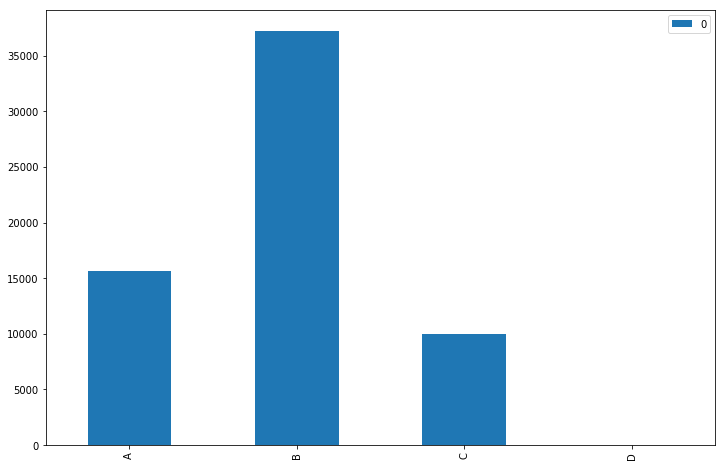

In [120]:
# cancellation_reason distribution plot

from collections import Counter

flights_copy = flights.copy()

cancellation_reason = flights_copy.dropna(subset=['cancellation_reason'])['cancellation_reason']
counts = Counter(cancellation_reason)

df = DataFrame.from_dict(counts, orient='index')
df.plot(kind='bar')

De seguida iremos analisar, para cada companhia aérea, a percentagem de voos cancelados.
<br><br>
<div class="alert alert-success">
Q.6 <br>
    Construa o dataframe <code>g</code>, onde para cada <code>airline</code> tem uma coluna com o número de voos cancelados e uma coluna com o total de voos.
</div>

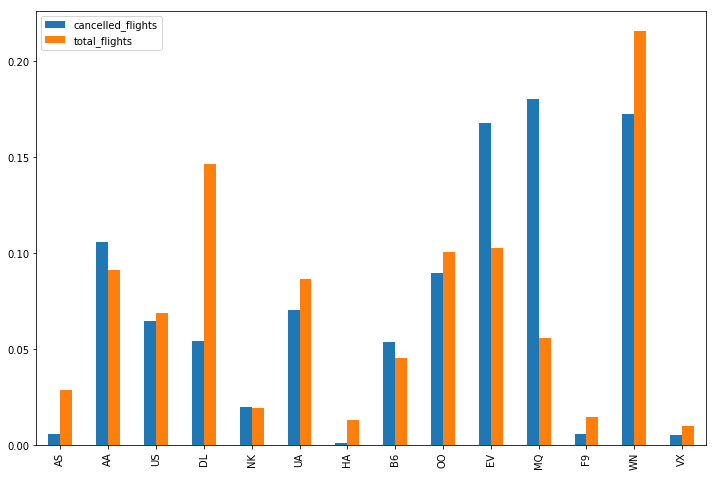

In [121]:
data = [flights.cancelled] 
  
g = pd.DataFrame(columns=['cancelled_flights', 'total_flights'], index=flights.airline.unique())
g.cancelled_flights = flights.airline[flights.cancelled==1].value_counts()
g.total_flights = flights.airline.value_counts()


#g.columns = ['cancelled_flights', 'total_flights']
g.cancelled_flights = g.cancelled_flights / g.cancelled_flights.sum()
g.total_flights = g.total_flights / g.total_flights.sum()

g.plot.bar()


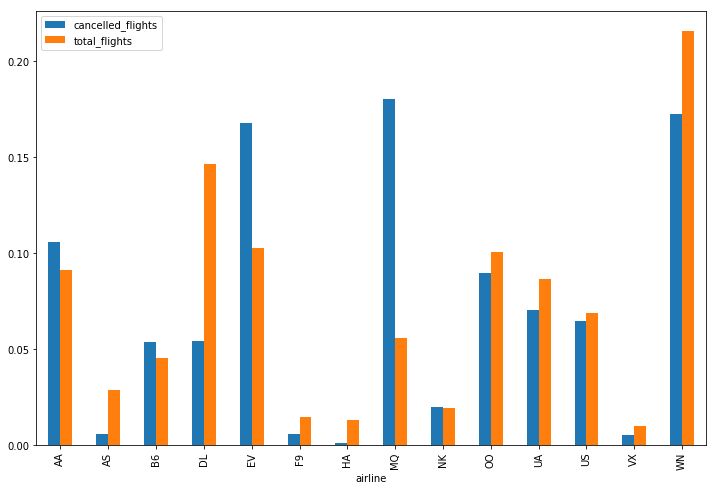

In [122]:
# the bar plot should be similar to this plot

from IPython.display import display, HTML
display(HTML('''
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAswAAAHrCAYAAADbkMsJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvqOYd8AAAIABJREFUeJzt3X2UnWV9L/zvz0AJJYi8VVvwmNDiCwYImmARQUtVQF2gVSrYKhQVq6KUtjxS7bIp2i4ULVWrVaoexUfFCqd90sqpVbEF5aBEDSAvKi8RQykHQRFqefV6/tg7cQjJlT2QyZ4dPp+1ZrH3fd97z3cPk5nvXPu6r7taawEAANbtEeMOAAAAs5nCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHVuMO8DadtpppzZ//vxxxwAAYDP3jW9844ettZ03dNysK8zz58/P8uXLxx0DAIDNXFV9f5TjTMkAAIAOhRkAADoUZgAA6Jh1c5jX5Z577smqVaty5513jjsKM2Du3LnZdddds+WWW447CgDAA0xEYV61alW23XbbzJ8/P1U17jhsRK213HLLLVm1alUWLFgw7jgAAA8wEVMy7rzzzuy4447K8maoqrLjjjt69wAAmLUmojAnUZY3Y/7fAgCz2cQUZgAAGIeJmMO8tvknf26jPt/KU5+/UZ9vY/nYxz6W5cuX52/+5m+ydOnSzJs3L3/8x3888uPnzZuXO+64Y737TzrppJx77rl53vOel2222WbN87/1rW/NgQcemGc/+9nrfez68vz4xz/Opz71qbzuda8bOScAwGxmhPlh7Iwzzsill16a00477X7bTznllG5Z7vnxj3+cD3zgAxsjHgDArKAwT8OZZ56ZvfbaK3vvvXde/vKX55/+6Z/ytKc9Lfvss0+e/exn56abbkoyGH099thj86xnPSu77bZb3vve9673OZLk5ptvzotf/OIsWbIkS5YsyVe/+tVujmuuuSaHHHJInvrUp+aAAw7IVVddlSS57rrrst9++2XPPffMn/7pn3af47DDDssdd9yRpz71qfnMZz5zv33HHHNMzj777CTJueeemyc+8Yl56lOfmje+8Y15wQtesOa4K6644gGv8eSTT84111yTRYsW5aSTTsqNN96YAw88MIsWLcrChQtzwQUXjPKlBgCYNSZySsY4XH755Xn729+eCy+8MDvttFNuvfXWVFUuuuiiVFU+/OEP553vfGfe/e53J0muuuqqfPnLX87tt9+eJzzhCXnta1+b7373uw94jiQ54YQTcuKJJ+YZz3hGrr/++hx88MG58sor15vluOOOywc/+MHsvvvu+drXvpbXve51Oe+883LCCSfkta99bV7xilfk/e9/f/f1LFu2LPPmzcuKFSuSDEr+2u6888685jWvyfnnn58FCxbkqKOOut/+db3GU089Nd/+9rfXPO+73/3uHHzwwXnLW96S++67Lz/96U9H/poDAMwGCvOIzjvvvBxxxBHZaaedkiQ77LBDLrvssrz0pS/NjTfemLvvvvt+6wg///nPz1ZbbZWtttoqv/RLv5Sbbrppnc+RJF/84hdzxRVXrHnsT37yk/XOPb7jjjty4YUX5ogjjliz7a677kqSfPWrX80555yTJHn5y1+eN73pTQ/pNV911VXZbbfd1ryuo446KmeccUb3Na5tyZIlOfbYY3PPPffkhS98YRYtWvSQMgEAbGqmZDwEb3jDG3L88cfnsssuy4c+9KH7rSW81VZbrbk9Z86c3Hvvvet9np/97Ge56KKLsmLFiqxYsSI33HBD5s2bt95jH/WoR605dsWKFfcbjd6US7SN8hoPPPDAnH/++dlll11yzDHH5Mwzz9xk+QAANgaFeUQHHXRQPvvZz+aWW25Jktx666257bbbsssuuyRJPv7xjz+o50iS5z73uXnf+9635rjV0xnW5ZGPfGQWLFiQz372s0kGV8q75JJLkiT7779/zjrrrCTJJz/5yem+xAd4whOekGuvvTYrV65MkgfMdV6XbbfdNrfffvua+9///vfz6Ec/Oq9+9avzqle9Kt/85jcfci4AgE1pIqdkjGMZuCc/+cl5y1vekmc+85mZM2dO9tlnnyxdujRHHHFEtt9++xx00EG57rrrpv0cH/vYx/Le9743r3/967PXXnvl3nvvzYEHHpgPfvCD632eT37yk3nta1+bt7/97bnnnnty5JFHZu+998573vOevOxlL8s73vGOHH744Q/5NW+99db5wAc+kEMOOSTbbLNNlixZssHH7Ljjjtl///2zcOHCHHrooVm4cGFOO+20bLnllpk3b54RZgBg4lRrbdwZ7mfx4sVt+fLl99t25ZVX5klPetKYEj283XHHHZk3b15aa3n961+f3XffPSeeeOJG/zz+HwMAm1pVfaO1tnhDx5mSQdff/d3fZdGiRXnyk5+c2267La95zWvGHQkAYJOayCkZjO6yyy5bs97zaltttVW+9rWvjfT4E088cUZGlAEANmjpdtM8/rYZiaEwb+b23HPP7kmEAAD0mZIBAAAdCjMAAHQozAAA0DGZc5inOwF8g883MxPEAQCYfEaYR/TjH/84H/jAB7rHrFy5Mp/61Kc2+FwrV67MwoULu8ccddRR2WuvvXL66afnmGOOydlnn50kedWrXpUrrrii+9ipxz+YfAAA/JzCPKKNWZg35D//8z9z8cUX59JLL33Akm4f/vCHs8ceezyo51WYAQCmT2Ee0cknn5xrrrkmixYtykknnZSTTjopCxcuzJ577pnPfOYza4654IILsmjRopx++ulZuXJlDjjggDzlKU/JU57ylFx44YUjfa7nPve5ueGGG7Jo0aJccMEF99v3rGc9K6uvhPiRj3wkj3/847Pvvvvm1a9+dY4//vg1x51//vl5+tOfnt12223NaPPa+S6//PLsu+++WbRoUfbaa69873vf2xhfKgCAzcpkzmEeg1NPPTXf/va3s2LFipxzzjn54Ac/mEsuuSQ//OEPs2TJkhx44IE59dRT8653vSv//M//nCT56U9/mi984QuZO3duvve97+Woo47K2pf9Xpdly5blBS94wZr1kz/ykY884Jj/+I//yNve9rZ885vfzLbbbpuDDjooe++995r9N954Y77yla/kqquuymGHHZaXvOQlD8j3hje8ISeccEJ+53d+J3fffXfuu+++jfGlAgDYrCjMD8JXvvKVHHXUUZkzZ04e/ehH55nPfGYuvvjiPPKRj7zfcffcc0+OP/74rFixInPmzMl3v/vdjZbh61//ep75zGdmhx12SJIcccQR93v+F77whXnEIx6RPfbYIzfddNM6n2O//fbLX/zFX2TVqlX5rd/6rey+++4bLR8AwObClIwZdPrpp+fRj350Lrnkkixfvjx33333JvvcW2211ZrbrbV1HvOyl70sy5Yty9Zbb53nPe95Oe+88zZVPACAiTGZI8xjWAZu2223ze23354kOeCAA/KhD30oRx99dG699dacf/75Oe2003LDDTesOSZJbrvttuy66655xCMekY9//OMbdcrDkiVL8gd/8Af50Y9+lG233TbnnHNO9txzz5FfQ5Jce+212W233fLGN74x119/fS699NIcdNBBGy0jAMDmYDIL8xjsuOOO2X///bNw4cIceuih2WuvvbL33nunqvLOd74zj3nMY7Ljjjtmzpw52XvvvXPMMcfkda97XV784hfnzDPPzCGHHJJtttlmo+XZZZdd8uY3vzn77rtvdthhhzzxiU/Mdtv116fea6+97pfvrrvuyic+8YlsueWWecxjHpM3v/nNGy0fAMDmotb3dv24LF68uK19YtyVV16ZJz3pSWNKNHvdcccdmTdvXu6999686EUvyrHHHpsXvehF4471oPh/DAA8wHQvVjfNWQhV9Y3W2uINHWcO8wRbunRpFi1alIULF2bBggV54QtfOO5IAACbHVMyxujzn/983vSmN91v24IFC/IP//APIz3+Xe9610zEAgBgiokpzK21VNW4Y2xUBx98cA4++OBxxxi72TYtCABgqomYkjF37tzccsstitVmqLWWW265JXPnzh13FACAdZqIEeZdd901q1atys033zzuKMyAuXPnZtdddx13DACAdZqIwrzllltmwYIF444BAMDD0ERMyQAAgHFRmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoGOkwlxVh1TVd6rq6qo6eR37/7CqrqiqS6vqS1X1uCn7jq6q7w0/jt6Y4QEAYKZtsDBX1Zwk709yaJI9khxVVXusddi3kixure2V5Owk7xw+dockf5bkaUn2TfJnVbX9xosPAAAza5QR5n2TXN1au7a1dneSs5IcPvWA1tqXW2s/Hd69KMnqy7YdnOQLrbVbW2s/SvKFJIdsnOgAADDzRinMuyT5wZT7q4bb1ueVSf73dB5bVcdV1fKqWu7y1wAAzCYb9aS/qvrdJIuTnDadx7XWzmitLW6tLd555503ZiQAAHhIRinMNyR57JT7uw633U9VPTvJW5Ic1lq7azqPBQCA2WqUwnxxkt2rakFV/UKSI5Msm3pAVe2T5EMZlOX/O2XX55M8t6q2H57s99zhNgAAmAhbbOiA1tq9VXV8BkV3TpKPttYur6pTkixvrS3LYArGvCSfraokub61dlhr7daqelsGpTtJTmmt3TojrwQAAGbABgtzkrTWzk1y7lrb3jrl9rM7j/1oko8+2IAAADBOrvQHAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAxxbjDgDApjf/5M9N6/iVpz5/hpIAzH5GmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCAji3GHQAAgIeH+Sd/blrHr5w7Q0GmyQgzAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHS5cAhNs2gvAn/r8GUoCAJsvI8wAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQMdIhbmqDqmq71TV1VV18jr2H1hV36yqe6vqJWvtu6+qVgw/lm2s4AAAsClssaEDqmpOkvcneU6SVUkurqplrbUrphx2fZJjkvzxOp7iv1trizZCVgAA2OQ2WJiT7Jvk6tbatUlSVWclOTzJmsLcWls53PezGcgIAABjM8qUjF2S/GDK/VXDbaOaW1XLq+qiqnrhug6oquOGxyy/+eabp/HUAAAwszbFSX+Pa60tTvKyJH9dVb+69gGttTNaa4tba4t33nnnTRAJAABGM0phviHJY6fc33W4bSSttRuG/702yb8l2Wca+QAAYKxGKcwXJ9m9qhZU1S8kOTLJSKtdVNX2VbXV8PZOSfbPlLnPAAAw222wMLfW7k1yfJLPJ7kyyd+31i6vqlOq6rAkqaolVbUqyRFJPlRVlw8f/qQky6vqkiRfTnLqWqtrAADArDbKKhlprZ2b5Ny1tr11yu2LM5iqsfbjLkyy50PMCAAAY+NKfwAA0DHSCDMwtHS7aR5/28zkAAA2GSPMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdCjMAADQscW4AzxU80/+3LSOX3nq82coCQAAmyMjzAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0DHxq2QA07B0u2kef9vM5ACACWKEGQAAOkYqzFV1SFV9p6qurqqT17H/wKr6ZlXdW1UvWWvf0VX1veHH0RsrOAAAbAobLMxVNSfJ+5McmmSPJEdV1R5rHXZ9kmOSfGqtx+6Q5M+SPC3Jvkn+rKq2f+ixAQBg0xhlDvO+Sa5urV2bJFV1VpLDk1yx+oDW2srhvp+t9diDk3yhtXbrcP8XkhyS5NMPOTkAPFw4/wDGapQpGbsk+cGU+6uG20Yx0mOr6riqWl5Vy2+++eYRnxoAAGberDjpr7V2RmttcWtt8c477zzuOAAAsMYohfmGJI+dcn/X4bZRPJTHAgDA2I1SmC9OsntVLaiqX0hyZJJlIz7/55M8t6q2H57s99zhNgAAmAgbLMyttXuTHJ9B0b0yyd+31i6vqlOq6rAkqaolVbUqyRFJPlRVlw8fe2uSt2VQui9OcsrqEwABAGASjHSlv9bauUnOXWvbW6fcvjiD6RbreuxHk3z0IWQEAICxmRUn/QEAwGylMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHQozAAB0KMwAANChMAMAQIfCDAAAHVuMO8Amt3S7aR5/28zkAABgIhhhBgCADoUZAAA6Hn5TMgBgzOaf/LlpHb9y7gwFAUZihBkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADqskgEAzCwXDWPCGWEGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADq2GHcAAGCyzD/5c9M6fuXcGQoCm4gRZgAA6FCYAQCgw5QMAID1WbrdNI+/bWZyMFZGmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoENhBgCADoUZAAA6rMMMADysTOfS3i7rTWKEGQAAuhRmAADoUJgBAKBDYQYAgA6FGQAAOhRmAADoUJgBAKBDYQYAgA6FGQAAOhRmAADoUJgBAKBDYQYAgA6FGQAAOhRmAADoUJgBAKBDYQYAgI4txh0AgAmwdLtpHn/bzOQAGAMjzAAA0KEwAwBAhykZPKzNP/lz0zp+5dwZCgIAzFoKMw/JtAvnqc+foSQAADPDlAwAAOhQmAEAoENhBgCAjpEKc1UdUlXfqaqrq+rkdezfqqo+M9z/taqaP9w+v6r+u6pWDD8+uHHjAwDAzNrgSX9VNSfJ+5M8J8mqJBdX1bLW2hVTDntlkh+11n6tqo5M8o4kLx3uu6a1tmgj5wYAgE1ilBHmfZNc3Vq7trV2d5Kzkhy+1jGHJ/n48PbZSX6zqmrjxQQAgPEYpTDvkuQHU+6vGm5b5zGttXuT3JZkx+G+BVX1rar696o6YF2foKqOq6rlVbX85ptvntYLAACAmTTTJ/3dmOR/tNb2SfKHST5VVY9c+6DW2hmttcWttcU777zzDEcCAIDRjVKYb0jy2Cn3dx1uW+cxVbVFku2S3NJau6u1dkuStNa+keSaJI9/qKEBAGBTGaUwX5xk96paUFW/kOTIJMvWOmZZkqOHt1+S5LzWWquqnYcnDaaqdkuye5JrN050AACYeRtcJaO1dm9VHZ/k80nmJPloa+3yqjolyfLW2rIkH0nyiaq6OsmtGZTqJDkwySlVdU+SnyX5/dbarTPxQgAAYCZssDAnSWvt3CTnrrXtrVNu35nkiHU87pwk5zzEjAAAMDau9AcAAB0KMwAAdCjMAADQMdIcZtholm43zeNvm5kcAAAjMsIMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0LHFuAMwTUu3m+bxt81MDgCAhwkjzAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHRsMe4AADBd80/+3LSOX3nq82coCfBwoDADsPlbut00j79tZnIAE8mUDAAA6FCYAQCgQ2EGAIAOhRkAADoUZgAA6FCYAQCgQ2EGAIAOhRkAADpcuASYHNO5+IQLTwCwkRhhBgCADoUZAAA6TMkA2BSmM50kMaUEYBYxwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB1WyQAA2FxZoWejMMIMAAAdCjMAAHQozAAA0KEwAwBAh8IMAAAdCjMAAHQozAAA0GEd5jGbf/LnpnX8yrkzFATGwPc/AJNAYQYAmBAGGsbDlAwAAOhQmAEAoENhBgCADoUZAAA6FGYAAOhQmAEAoGOkwlxVh1TVd6rq6qo6eR37t6qqzwz3f62q5k/Z9yfD7d+pqoM3XnQAAJh5G1yHuarmJHl/kuckWZXk4qpa1lq7Ysphr0zyo9bar1XVkUnekeSlVbVHkiOTPDnJryT5YlU9vrV238Z+IQCbkrVQAR4+Rhlh3jfJ1a21a1trdyc5K8nhax1zeJKPD2+fneQ3q6qG289qrd3VWrsuydXD5wMAgIlQrbX+AVUvSXJIa+1Vw/svT/K01trxU4759vCYVcP71yR5WpKlSS5qrf2/w+0fSfK/W2tnr/U5jkty3PDuE5J856G/tPXaKckPZ/D5Z5r84yX/eE1y/knOnsg/bvKPzyRnT+TfkMe11nbe0EGz4tLYrbUzkpyxKT5XVS1vrS3eFJ9rJsg/XvKP1yTnn+TsifzjJv/4THL2RP6NZZQpGTckeeyU+7sOt63zmKraIsl2SW4Z8bEAADBrjVKYL06ye1UtqKpfyOAkvmVrHbMsydHD2y9Jcl4bzPVYluTI4SoaC5LsnuTrGyc6AADMvA1OyWit3VtVxyf5fJI5ST7aWru8qk5Jsry1tizJR5J8oqquTnJrBqU6w+P+PskVSe5N8vpZsELGJpn6MYPkHy/5x2uS809y9kT+cZN/fCY5eyL/RrHBk/4AAODhzJX+AACgQ2EGAIAOhRkAADoedoW5qh5bVSeNOweTraqeNu4MTKaqevS4MzycDVd7YkyqastxZ5iuqtp+ePXiWa2q5nX2/eqmzLI5elgU5qrauapeV1UXJPm3JLP+F1ZVPa6qtpty/zeq6j1V9YeT8gO/qv5HVc0d3q6q+r2qel9VvXa4Xvck++y4A2xIVV1RVX866T8oq2pxVb2oqg6rqieOO8+DUVWPqqpXVtWXknxr3HlGUVX7VNUnq+qbw48zqmr34b5Z/e+3qt66nu3bJfnXTRxn2qrq0Ko6v6p+OPz496p63rhzPVjDn/+/Obza76px5+mpqreu/jkzXBL3y0muSXJTVT17vOk26JKq+u2pG6pqblW9PYOVzma1qnpF72Pc+TbbwlxV21bV0VX1+QzWfv7VJAtaa7/aWvvjMccbxd8n2SZJqmpRBgXt+iR7J/nAGHNNx7n5+ffYqUmen+RrSZZkliwT8xDM+tGGJEdl8D30r1X19ao6sap+ZdyhRlVVz6yq5Rl873w0yXFJPlJV/1ZVj+0/evyqauuqOrKqliW5LMm7k7wtgws4zWpV9eIMfuZ8Kckxw4+Lkny2qvbL7P/l+4yq+oupG4Yj+/+e5LzxRBpNVb06g++TpUl2G378eZKlVXXcGKNNW1X9elW9N8n3k/x/Sc5PMtv/6H1pku8Mb6++vsTOSZ6Z5C/Hkmh0z03ye1X1r1X1a1V1eAY/e7ZKsmi80UayZD0fb8vgd8B4tdY2y48k/53BD8cD8vPl864dd65p5L90yu13JXnn8PYjpu6bzR9Jrphy+xtJHjHl/iXjzvcQX9v1484wzby/nuT0DP7o+nKSV4870wiZv5Vk5+HtBUn+YXj7OUn+ddz5NpD9U0l+kMEa9c/JYA3768adaxr5L00yfx3b5ye5M8lfjjvjBvLPTfLPSf5qeH/3JFcn+f1xZxsh+xVJdljH9h2TXDnufCO+hr9M8r0M/uB61TD7dePONWL2b025fU6S10y5/81x5xvxNZyUwbUvViV58rjzPMjXUEl+N4PC/5kke40702Y7wpzkTzL4q+oDSf5kAt+WnjqCeVAGP3jSWvtZJmN0M0l+UFUHDW+vzM8vn77j2BJNQ1X9U1UtW8fHP2XwC2BitNYuaq2dmOQVSR6V5G/GHGkUc1prNw9vX5/kcUnSWvtCkl3Glmo0eyT5UZIrMyg59yWZpEXvt2itrVx743Db91trb97kiaahtXZnkhclmV9Vn07yxSQntdY+ON5kI6nW2q1rb2yt3TKOMA/Sq5LclORvk3ximH3KhY20AAAJp0lEQVRSvv/vqqqFVbVzkt/I/afw/OKYMo2kqraoqj9J8vtJXpdkeZL3VtUTxptsdMPX8KoMfnY+O8lLWmsvba1dOuZoG77S36Rqrf11kr+uqt0yuPLgPyb5lap6UwYjVd8da8ANO294lcQbk2yf4duIVfXLGYzwTIJXJTmzqpYmuS3JiqpakUFh+8NxBhvRux7kvlmlqpZkMD3jxUmuS/KhTMAc7CTLh3Mez0tyWAbnH6SqfjGDEdtZq7W2aDgP8qgkX6yqHybZtqoe3Vq7aczxRnFPVf2P1tr1UzdW1eOS3DWmTCOrqtU/X76W5P9JckGSBau3t9b+alzZRvCTqtq7tXbJ1I1VtXeS28eUabp+OYN3Vo7K4Pfwl5NsXVVbtNbuHW+0DTohydkZTMP4q9badUkynEM+288/+FYG76w/pbV2W5IzquoFSZZV1Tmz/Q/dqnp9Bl//LyU5ZF1/tI/Tw+pKf1W1MMl7MnircVaPOFdVZTCX6peT/H1r7Ybh9gOSfGy255+qqp6U5PEZ/IG2KsnFw5HyiTEcbciUEc9Zr6r+MoPvoVuTnJXkM621WX3CzVQ1OJv+1RmM1l6S5KOttfuqauskv9Ra+/5YA05DVT01ycuSHJFkVWvt6WOO1FVVL0zyzgzeWv/GcPPiJCcneVNr7R/HlW0UVfVnvf2ttT/fVFmmq6qekeSTSf5n7v+1PzrJ77bWvjKubA9GVW2V5AUZlOcDknyptfay8aZav+EfVavfxW3Djx8m+crq8jxbVdW5GUyX+spa27dO8qettbeMJ9loqupnSf5vkptz/3ckKklrre01lmCrQzwcCnNV7ZPBP9bfzmBqwDmttfeNNdQ0DPOv/mV7XZL/NUn5p6qqnZLc0ibkG2/4i/cNGcwdrwzmhb2vtXbKWIONYLhSwKdba98bd5YHY10jnJNu+IfwAa2188edZUOGI5p/lOTJw01XJHnX2iOfbHzDExT/KIMT/pLB7613tdb+c2yhpmHKCP9qq0vnJUkWtdbO3PSpRrOeP7Z2SHJwkqWttbM2caSRVdUJGbyj/ssZLBzw6dbabB8VX6OqTkzy1QwGee5Ze/+4B0k22ykZVfX4DEryURn8Q/1MBn8gPGucuUbVyf8bYw02DVX16xmscHBrBme5fiLJTkkeUVWvaK39yzjzbcjwh/4zkiyZ8rbcbkn+tqpObK2dPtaAG3bn6rJcVUe01tZMw6iqv5ztb89lMI3qKUkyfDvxxWPOM7Kqel/6czZnfWEeFuOxL+X0YNR6lpUbaq21t22yMNNUgyX7/ijJsRnM3U+SZyX5WVW9pbX2gCIxC227jm3zk7wlgxU/Zq31vftQVTtkMBd+1hbm1tp7krxnOHXqyCQfHY4ufzrJpyZg8GSXJH+dwUoql2VQni9McuG65vVvapvtCPNwaP+CJK9srV093HZta223/iNnh0nPnyTDJcHenGS7DJaRO7S1dtFwbuenW2v7jDXgBlTVt5I8p7X2w7W275zBKg2zPf83W2tPWfv2uu7PRlX1rdVf46m3J0FVHT3l7p8nud+oVWvt45s20fQMl8Jbr9baYZsqy4NRVX+0js3bJHllkh1ba+u9wMO4VdXpGRTOE1trtw+3PTKD8yb+u7V2wjjzPRSrS+ds/9mzPpP2cyhZ8w71RzNYZWJWn/uxWg2uNbE4ydOT7Df8+HFrbY9x5tpsR5iT/FYGf2F9uar+JYO/CidldYlk8vMngzPt/zVJquqU1tpFSdJau6pm/0WTkmTLtctyMpjHXJNxtapaz+113Z+N2npuz3pTC3FV/cFsL8jrsF8Gy+J9OoMT5ybh+2WN1tq7V9+uqm0zOJHo9zL4Ofru9T1ulnhBksdPnbbWWvtJVb02yVUZvJaJ1Fq7tSbkh//aquo3Mlj5ZtYbvktxaAYd4jczOGF66RgjTdfWSR6ZwWDbdkn+I4MR57HabAvz8KSUf6yqbZIcnuQPkvxSVf1tBqtkzOqrPU16/qGpJ/b991r7JqEA3f0g980WvcI5CV//vavqJxmUta2Ht5OfnwDyyPFFm5ZJ+Fqv7TH5+SoHL0vyuQzeFbp8rKmmYTia+YdJfifJxzNYOWASCk9b1zkewxNeJ/F7aY1JKJ1VdVke+G92hwxK26yeolRVq//NPi+DC7adleS41tp/jTXYiKrqjAzOmbg9gz/UL8xgpZJZ8T2z2U7JWJeq2j6DE+de2lr7zXHnma5Jy19V9yX5rwwLT5Kfrt6VZG5rbVaP0k7J/4Bdmaz8E/n131xMwvSXnuEqB0clOS3Jn7fWZv0a3lV1Wgbv0p2R5P2ttTvGHGlkVfWPGZzYfeZa2383yW/P9ukwyYZLZ2vtqk2fajTD+b9TtQxOVJ/1pbOqzsvgoknnzJaSOR3Dd9N3SvLtDMry/0ny7dmySMDDqjADbApVdXt+Xhh+Mff/Y2UiRseHRfn5GZTl+UmWZbC03w3jzDWK4Tkgd2Wwqs26lqeatV//qtolyf/K4F25qcvKbZ3kRRPy9Z/Y0sl4DafsPDmD+ctPT7Iwg4UD/k9rrbtc5IxnU5gBmKqqzszgF9W5Sc5qrX17zJEedmpwldQ1S/q11r40zjywKVXVrkn2z6A0vyCDk3UfNdZMCjMAUw1HaFePBk7UCC0wmarqjfn5yPI9GS4pN/y4bNwXPNtsT/oD4MFprT1i3BmAh535ST6bwZKKN445ywMYYQYAgA6jCAAA0KEwAwBAh8IMMMtV1blVtc4zxKtqZVXtNLx94aZNBvDwYA4zwAQarldaSa5Nsnhdl3EHYOMwwgwwi1TVP1bVN6rq8qo6brhtZVXtVFXzq+o7w3WSv53ksWs99o7hf59VVf9WVWdX1VVV9clhwU5VPbWq/n34OT5fVb+8qV8jwKSxrBzA7HJsa+3Wqto6ycVVdc5a+3dPcnRr7aIkGfbgddkngwtf/EeSrybZv6q+luR9SQ5vrd1cVS9N8hdJjp2B1wGw2VCYAWaXN1bVi4a3H5tBQZ7q+6vL8gZ8vbW2KkmqakUGa5z+OIMr+H1hWLTnJJl1650CzDYKM8AsUVXPSvLsJPu11n5aVf+WZO5ah/3X2o9bj7um3L4vg5/3leTy1tp+DzEqwMOKOcwAs8d2SX40LMtPTPLrG/n5v5Nk56raL0mqasuqevJG/hwAmx2FGWD2+JckW1TVlUlOTTLK1IuRtdbuTvKSJO+oqkuSrEjy9I35OQA2R5aVAwCADiPMAADQoTADAECHwgwAAB0KMwAAdCjMAADQoTADAECHwgwAAB0KMwAAdPz/LkogeK7KGxgAAAAASUVORK5CYII=&#10">
'''))

Com este gráfico verificamos que as companhias aéreas EV e MQ têm, percentualemnte, muito mais voos cancelados do que voos concluídos. Normalmente este tipo de informação é útil para melhorar a performance dos modelos (através de técnicas como one-hot encoding).

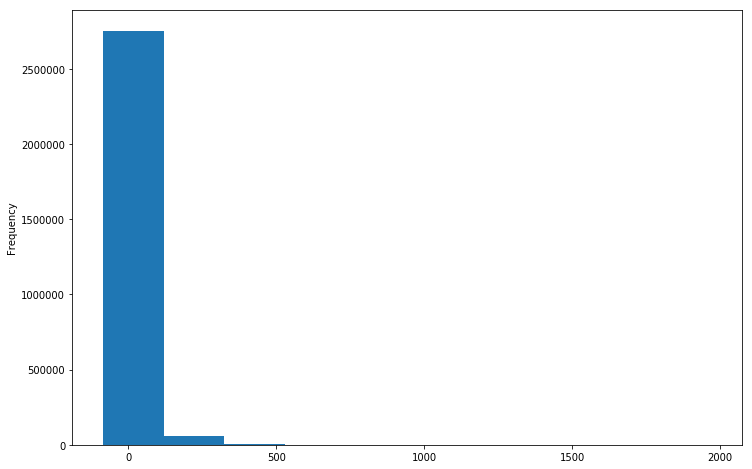

In [123]:
# arrival_delay histogram
flights.arrival_delay.plot.hist()

Analisando o histograma do campo `arrival_delay` podemos logo observar que grande maioria dos valores está concentrada numa região. A este tipo de gráficos costuma-se chamar de long tail distribution.
<br><br> 
Uma maneira de melhor analisar este tipo de gráficos é agrupar todos os valores acima de um determinado percentil, de forma ao histograma criar mais bins na zona que nos interessa analisar.
<br><br>
<div class="alert alert-success">
Q.7<br>
    Sendo <code>p</code> o valor do percentil 95% da coluna <code>arrival_delay</code>.
    <br><br>
    Crie a coluna <code>arrival_delay_copy</code> (cópia da coluna <code>arrival_delay</code>) de forma a que todos os seus valores acima de <code>p</code>, sejam convertidos para <code>p+1</code> e construa um histograma com 20 bins.
    <br><br>
    <span class="badge">Nota:</span> Para alterar um subconjunto de uma coluna do dataframe é aconselhado usar o método <code>loc</code>.
    <br><br>
    <span class="badge">Nota:</span> O método <code>pd.cut</code> poderia ser usado para definir as bins e usava-se um gráfico de barras para simular o histograma. Como?
</div>

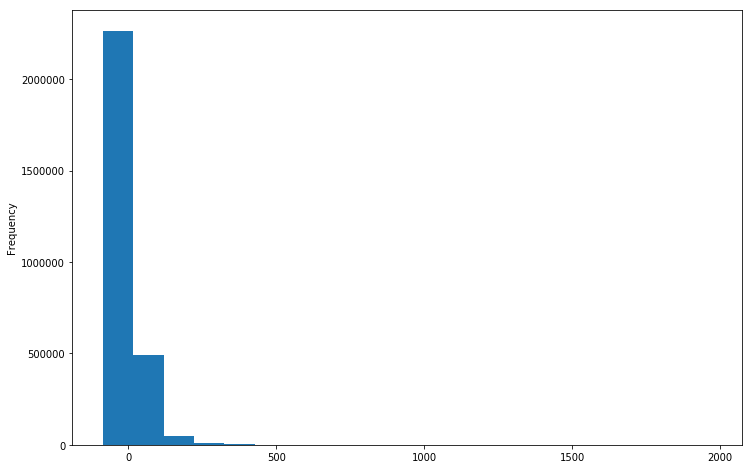

In [124]:
# histogram of arrival delay, where we grouped all values > 95% quantile

flights['arrival_delay_copy'] = flights.arrival_delay.copy()

# 95% quantile
p = flights['arrival_delay_copy'].quantile(0.95)


flights.loc[p,'arrival_delay_copy'] = p+1
flights.arrival_delay_copy.plot.hist(bins=20)

Agora percebe-se muito melhor a distribuição desta coluna.

#### 1.2 Análise temporal

Para a nossa análise temporal vamos começar por colocar a data como índice.

In [0]:
flights.set_index('date', inplace=True, drop=False)
flights.index.names = ['date_index'] # avoid ambiguitiy with column 'date'

<div class="alert alert-success">
Q.8<br>
    Para os meses de Janeiro e Fevereiro, mostre um plot com o número de voos por dia.
    <br><br> 
    <span class="badge">Nota:</span> para filtrar os meses use slicing de datas no índice (aula 5, secção 2.3)
</div>

Text(0.5, 1.0, 'Number of flights per day of week')

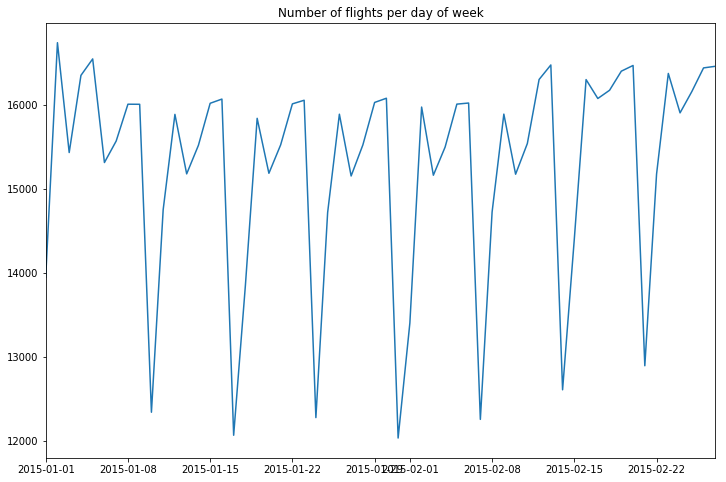

In [126]:
import matplotlib.pyplot as plt
from pandas import datetime as dt
# daily flights 

start_date = flights.index.searchsorted(dt(2015, 1, 1))
end_date = flights.index.searchsorted(dt(2015, 2, 28))

jan_feb = flights[start_date:end_date]

flights_per_day = jan_feb.groupby(jan_feb.index.date).count()['day']

flights_per_day.plot()
plt.title("Number of flights per day of week")




Ao analisar a distribuição do número de voos por dia, podemos observar que parece have periodicidade no decréscimo do número de voos, será o fim de semana?
<br><br>
<div class="alert alert-success">
Q.9 <br>
    Adicione a coluna <code>day_of_week</code> com o dia da semana do ano e mostre um plot com o número de voos por dia da semana (neste já poderemos usar a totalidade dos meses).
</div>

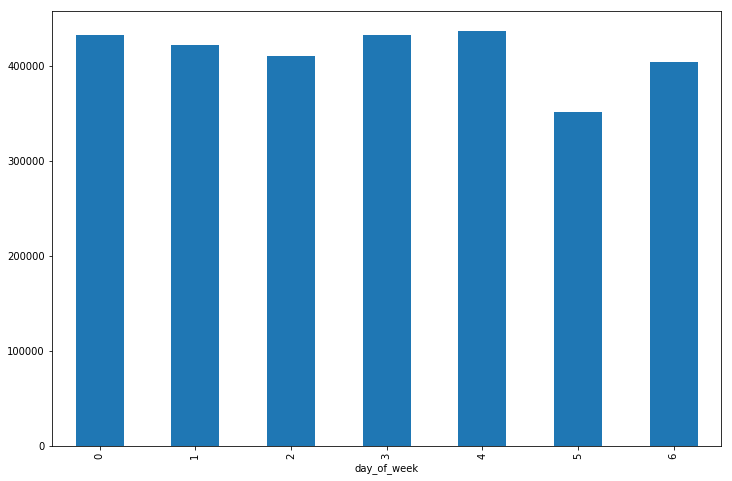

In [127]:
flights['day_of_week'] = flights.index.weekday
flights.groupby('day_of_week').is_delayed.count().plot.bar()

Parece que o dia da semana com menos voos é o sábado!
<br><br>
<div class="alert alert-success">
Q.10<br>
    Transforme o gráfico anterior em percentagem e adicione uma barra com a percentagem de voos atrasados por dia da semana.
</div>

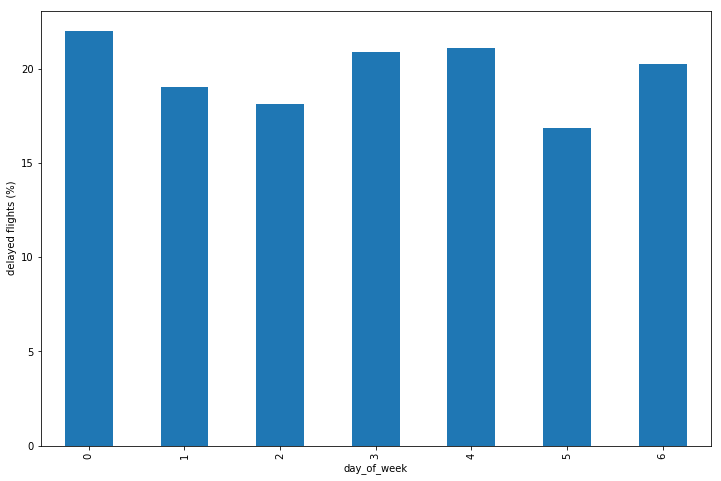

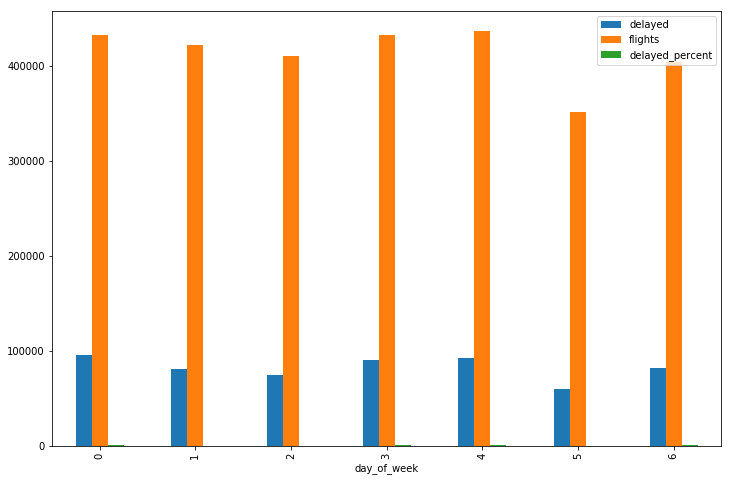

In [128]:
g = flights.groupby('day_of_week').is_delayed.agg(['sum','count'])
g.columns = ['delayed', 'flights']

# transfrom g to percentage here

g['delayed_percent'] = (g.delayed / g.flights)*100
ax = g.delayed_percent.plot.bar()
ax.set_ylabel(r'delayed flights (%)')



g.plot.bar()

<div class="alert alert-success">
Q.11<br>
    Utilizando o método <code>pivot_table</code> construa um dataframe com a percentagem de voos atrasados por airline (índice das colunas) para cada dia da semana (índice das linhas).
</div>

In [129]:
# the pivot_table should have this format
#
# airline        AA    AS    B6    DL    EV    F9    HA    MQ    NK    OO    UA    US    VX    WN
# day_of_week                                                                                    
# 0           0.238 0.134 0.282 0.170 0.238 0.333 0.095 0.277 0.351 0.206 0.252 0.195 0.230 0.212
# 1           0.174 0.110 0.221 0.158 0.213 0.272 0.080 0.249 0.321 0.183 0.222 0.185 0.168 0.182
# 2           0.183 0.110 0.183 0.134 0.212 0.332 0.107 0.243 0.284 0.191 0.202 0.159 0.133 0.174
# 3           0.213 0.128 0.226 0.156 0.220 0.322 0.129 0.264 0.297 0.192 0.254 0.196 0.206 0.215
# 4           0.223 0.145 0.221 0.153 0.210 0.314 0.168 0.281 0.324 0.195 0.240 0.195 0.215 0.222
# 5           0.191 0.110 0.204 0.121 0.167 0.287 0.129 0.194 0.296 0.152 0.200 0.167 0.120 0.165
# 6           0.218 0.138 0.231 0.137 0.213 0.314 0.089 0.255 0.340 0.199 0.237 0.186 0.232 0.205

import pandas as pd


delayed_by_airline_percent = pd.pivot_table(flights, index='day_of_week', columns='airline', values='is_delayed')
delayed_by_airline_percent.sort_index()




airline,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
day_of_week,,,,,,,,,,,,,,
0,0.238,0.134,0.282,0.170,0.238,0.333,0.095,0.277,0.351,0.206,0.252,0.195,0.230,0.212
1,0.174,0.110,0.221,0.158,0.213,0.272,0.080,0.249,0.321,0.183,0.222,0.185,0.168,0.182
2,0.183,0.110,0.183,0.134,0.212,0.332,0.107,0.243,0.284,0.191,0.202,0.159,0.133,0.174
3,0.213,0.128,0.226,0.156,0.220,0.322,0.129,0.264,0.297,0.192,0.254,0.196,0.206,0.215
4,0.223,0.145,0.221,0.153,0.210,0.314,0.168,0.281,0.324,0.195,0.240,0.195,0.215,0.222
5,0.191,0.110,0.204,0.121,0.167,0.287,0.129,0.194,0.296,0.152,0.200,0.167,0.120,0.165
6,0.218,0.138,0.231,0.137,0.213,0.314,0.089,0.255,0.340,0.199,0.237,0.186,0.232,0.205


#### 1.3 Considerando informação de contexto

A informação de contexto que será usada é a presente no dataframe `airports`, pois podemos adicionar várias informações úteis relativas aos aeroportos de partida e chegada do voo.
<br><br>
<div class="alert alert-success">
Q.12<br>
    Crie o dataframe <code>flights_context_info</code> com base no dataframe <code>flights</code> onde se adiciona todas as colunas do dataframe <code>airports</code> como informação de contexto para a coluna <code>origin_airpot</code>. Adicione também a mesma informação de contexto para a coluna <code>destination_airport</code>.
</div>

In [130]:
  
  
flights_context_info = pd.DataFrame(flights, columns=airports.columns)


# selecting necessary fields
airports = airports[['iata_code', 'city', 'state']]


flights_tmp = pd.merge(flights, airports, left_on='origin_airport', right_on='iata_code') # add origin_airport context information


flights_context_info = pd.merge(flights_tmp, airports, left_on='destination_airport', right_on='iata_code') # add destination_airport context information

flights_context_info.head(3)

# free up RAM
#del flights_tmp

,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed,date,arrival_delay_copy,day_of_week,iata_code_x,city_x,state_x,iata_code_y,city_y,state_y
0,2015,1,1,AS,ANC,SEA,5,-11.000,205.000,194.000,169.000,1448,-22.000,0,NaN,nan,nan,nan,nan,nan,False,2015-01-01,-22.000,3,ANC,Anchorage,AK,SEA,Seattle,WA
1,2015,1,1,AS,ANC,SEA,45,-4.000,204.000,194.000,173.000,1448,-14.000,0,NaN,nan,nan,nan,nan,nan,False,2015-01-01,-14.000,3,ANC,Anchorage,AK,SEA,Seattle,WA
2,2015,1,1,DL,ANC,SEA,45,-14.000,210.000,200.000,171.000,1448,-24.000,0,NaN,nan,nan,nan,nan,nan,False,2015-01-01,-24.000,3,ANC,Anchorage,AK,SEA,Seattle,WA


<div class="alert alert-success">
Q.13<br>
    Calcule o top-10 dos pares (cidades de origem, cidade de destino) com mais voos atrasados (em valor absoluto).
</div>

In [131]:
flights_context_info['ori-dst'] = flights_context_info[['city_x', 'city_y']].apply(lambda x: '-'.join(x) , axis = 1) 

flights_context_info.groupby('ori-dst').is_delayed.sum().sort_values(ascending=False).head(10)

flights_context_info.head(3)



,year,month,day,airline,origin_airport,destination_airport,scheduled_departure,departure_delay,scheduled_time,elapsed_time,air_time,distance,arrival_delay,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay,is_delayed,date,arrival_delay_copy,day_of_week,iata_code_x,city_x,state_x,iata_code_y,city_y,state_y,ori-dst
0,2015,1,1,AS,ANC,SEA,5,-11.000,205.000,194.000,169.000,1448,-22.000,0,NaN,nan,nan,nan,nan,nan,False,2015-01-01,-22.000,3,ANC,Anchorage,AK,SEA,Seattle,WA,Anchorage-Seattle
1,2015,1,1,AS,ANC,SEA,45,-4.000,204.000,194.000,173.000,1448,-14.000,0,NaN,nan,nan,nan,nan,nan,False,2015-01-01,-14.000,3,ANC,Anchorage,AK,SEA,Seattle,WA,Anchorage-Seattle
2,2015,1,1,DL,ANC,SEA,45,-14.000,210.000,200.000,171.000,1448,-24.000,0,NaN,nan,nan,nan,nan,nan,False,2015-01-01,-24.000,3,ANC,Anchorage,AK,SEA,Seattle,WA,Anchorage-Seattle


___
### 2. Gerar dataset histórico, de treino e de teste
___

#### 2.1 Motivação

Normalmente os dados são divididos aleatoriamente nos conjuntos de treino, validação e teste. Contudo, esta abordagem não funciona em alguns domínios devido a uma dependência temporal dos dados. Neste exemplo, o avião `X` pode-se atrasar no voo `Y` devido a um voo anterior `Z`. Assim sendo, não podemos dividir o dataset tal que o voo `Z` vá para treino e o `Y` para teste.
<br><br>
Dessa forma iremos usar Jan e Feb como dataset histórico, Mar e Abr para treino e Mai e Jun para testes. Não estamos a criar um dataset de validação, porquê?

#### 2.2 Construção dos datasets

<div class="alert alert-success">
    Q.14<br>
    Com base nas especificações de 2.1 construa os datasets.
</div>

In [0]:
hist = flights_context_info[(flights_context_info.month==1) | (flights_context_info.month==2)].copy().reset_index(drop=True)
train = flights_context_info[(flights_context_info.month==3) | (flights_context_info.month==4)].copy().reset_index(drop=True)
test = flights_context_info[(flights_context_info.month==5) | (flights_context_info.month==6)].copy().reset_index(drop=True)

# confirm number of rows per dataset
assert len(hist) == 899159
assert len(train) == 989463
assert len(test) == 1000890

___
### 3. Feature Engineering
___

Neste momento terminámos o DU e contruímos os conjuntos de treino e teste. Ou seja, estamos preparados para adicionar features (novas colunas) e testar o nosso modelo.
<br><br>
Mas antes vamos remover de memória toda a informação (dataframes e outras variáveis) que já não iremos necessitar.

In [0]:
for c in 'airlines airports flights columns_to_remove columns delays g p flights_context_info total_delay'.split():
    if c in globals():
        del globals()[c] 

#### 3.1 Usando dados históricos

A ideia do dataset histório é para nos permitir adicionar features ao conjunto de treino e teste, como a percentagem de voos atrasados daquela companhia aérea, usando apenas informação do passado.

<div class="alert alert-success">
Q.15<br>
    Com base nos dados históricos, adicione a coluna <code>perc_delayed_flights_airline</code> ao treino e teste com a percentagem de voos atrasados da companhia aérea.
</div>

In [0]:
delays_airline = hist.groupby('airline').is_delayed.mean().to_dict()
delays_airline


train['perc_delayed_flights_airline'] = train['airline'].map(delays_airline)

test['perc_delayed_flights_airline'] = test['airline'].map(delays_airline)

<div class="alert alert-success">
Q.16<br>
    Com base nos dados históricos, adicione a coluna <code>perc_delayed_flights_route</code> ao treino e teste com a percentagem de voos atrasados por par (cidade de origem, cidade de destino).
</div>

In [0]:
delays_airline = hist.groupby('ori-dst').is_delayed.mean().to_dict()

train['perc_delayed_flights_route'] = train['ori-dst'].map(delays_airline)

test['perc_delayed_flights_route'] = test['ori-dst'].map(delays_airline)

<div class="alert alert-success">
Q.17<br>
    Por fim, com base nos dados históricos, adicione as colunas <code>avg_delay_city</code> e <code>avg_delay_airline</code> ao treino e teste com a média de atraso dos voos da cidade de origem e da airline, respectivamente.
</div>

In [0]:
avg_delay_city = hist.groupby('city_x').departure_delay.mean().to_dict()
avg_delay_airline = hist.groupby('airline').airline_delay.mean().to_dict()

# code here

train['avg_delay_city'] = train['city_x'].map(avg_delay_city)# code here
test['avg_delay_city'] = test['city_x'].map(avg_delay_city)# code here

# code here

train['avg_delay_airline'] = train['airline'].map(avg_delay_airline)# code here
test['avg_delay_airline'] = test['airline'].map(avg_delay_airline) # code here

#### 3.2 Novos campos temporais

<div class="alert alert-success">
Q.18<br>
    Como já temos uma coluna com o dia da semana, iremos apenas adicionar as seguintes colunas ao treino e teste:
    <ul>
        <li><code>is_weekend</code>: 1, se o dia da semana for 5 ou 6, 0 caso contrário</li>
        <li><code>is_monday</code>: 1, se o dia da semana for 0, 0 caso contrário</li>
        <li><code>is_saturday</code>: 1, se o dia da semana for 5, 0 caso contrário</li>
    </ul>
</div>

In [0]:
def add_temporal_features(df):
    
    df['is_weekend'] = [1 if x == 5 or x == 6 else 0 for x in df.day_of_week]
    df['is_monday'] = [1 if x == 0 else 0 for x in df.day_of_week]
    df['is_saturday'] = [1 if x == 5 else 0 for x in df.day_of_week]


add_temporal_features(train)
add_temporal_features(test)

#### 3.3 Risky features e OHE

<div class="alert alert-success">
    Q.19<br>
    Adicione a coluna <code>is_risky_airline</code> que terá o valor 1 caso a companhia aérea for <code>NK, F9, MQ ou EV</code> e 0 caso contrário, ao treino e teste.
</div>

In [0]:
risky_airlines = ['NK', 'F9', 'MQ', 'EV']
risk = {k: 1 if k in risky_airlines else 0 for k in hist.airline}
train['is_risky_airline'] = train['airline'].map(risk)
test['is_risky_airline'] = test['airline'].map(risk) 

<div class="alert alert-success">
Q.20<br>
    Adicione a coluna <code>is_risky_city</code> que terá o valor 1 caso a cidade de origem ou a cidade de destino for <code>New York, Boston, Chicago, San Francisco, Los Angeles ou Atlanta</code> e 0 caso contrário, ao treino e teste.
</div>

A função <code>my_is_risky_city</code> terá de ser usada para se comparar strings ignorando maiúsculas e espaços.

In [0]:
risky_cities = 'newyork boston chicago sanfrancisco losangeles atlanta'.split()

def my_is_risky_city(city):
    return city.replace(' ', '').lower() in risky_cities

train['is_risky_city'] = [np.max([my_is_risky_city(x), my_is_risky_city(y)]).astype(int) for x, y in zip(train.city_x, train.city_y)]
test['is_risky_city'] = [np.max([my_is_risky_city(x), my_is_risky_city(y)]).astype(int) for x, y in zip(test.city_x, test.city_y)]

<div class="alert alert-success">
Q.21<br>
    Utilizando a função <code>apply_ohe</code> da primeira parte do trabalho ou adicionando manualmente as colunas. 
    <br><br>
    Adicione, com base nos dados históricos, o OHE do top-5 de aeroportos de partida com mais voos atrasados, ao treino e teste.
</div>

In [0]:
categories_ohe = hist.groupby('origin_airport').is_delayed.mean().sort_values(ascending=False).head(5).index.values

# apply OHE in train and test
def apply_ohe(categories):
  ohe = np.eye(len(categories))
  return {k: ohe[:,n] for n, k in enumerate(categories)}


for k in categories_ohe:
    train['origin_airport_{0!s}'.format(k)] = train.origin_airport.map({k: apply_ohe(categories_ohe)[k]})
    test['origin_airport_{0!s}'.format(k)] = test.origin_airport.map({k: apply_ohe(categories_ohe)[k]})

#### 3.4 Normalizar colunas

<div class="alert alert-success">
Q.22<br>
    Com base na média e desvio padrão da coluna <code>distance</code> dos dados históricos, adicione a coluna <code>distance_normalized</code> com a utilização da normalização <code>z_score</code> na coluna <code>distance</code>.
</div>

In [0]:
def z_score(df, column, mean, std):
    return (df[column] - mean) / std

mean = hist.distance.mean()
std = hist.distance.std()

train['distance_normalized'] = z_score(train, 'distance', mean, std)
test['distance_normalized'] = z_score(test, 'distance', mean, std)

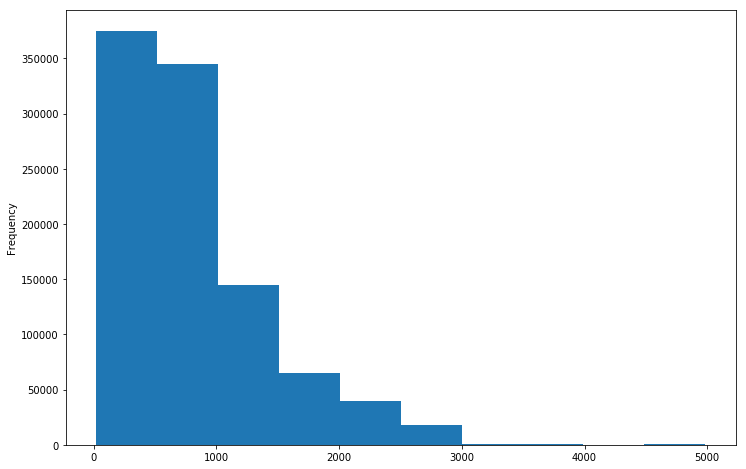

In [145]:
train.distance.plot.hist() 

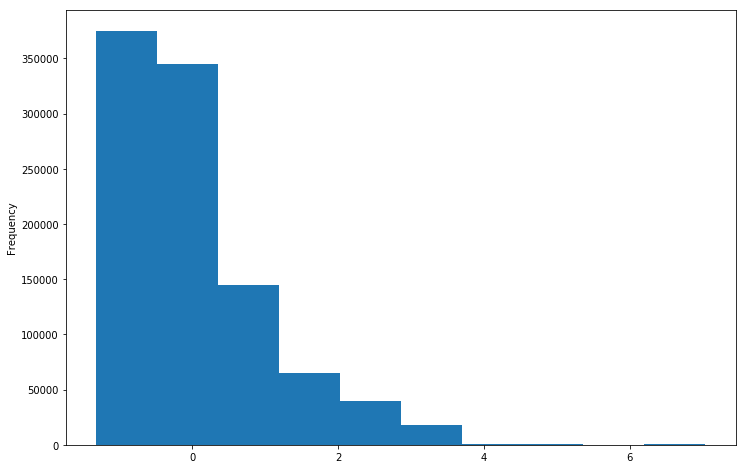

In [146]:
train.distance_normalized.plot.hist()

#### 3.5 Outras colunas

<div class="alert alert-warning">
Q.23<br>
    Esta secção é opcional.
    <br><br>
    Adicione outras features que pense serem preditivas na identificação de atrasos em voos.
</div>

#### 3.6 Remover colunas desnecessárias

Neste momento temos imensas colunas ou que não podem ser usadas para treinar o modelo (p.e. `arrival_delay`) ou que não fazem sentido usar (p.e. `year`) ou porque o modelo não suporta (p.e. colunas do tipo string). Assim vamos remover todas as colunas desnecessárias.

In [0]:
ohe = ['origin_airport_%s' % categ for categ in categories_ohe]

columns_to_keep = 'is_delayed day_of_week departure_delay scheduled_departure scheduled_time perc_delayed_flights_airline perc_delayed_flights_route avg_delay_city avg_delay_airline is_weekend is_monday is_saturday is_risky_airline is_risky_city distance_normalized'.split()
columns_to_keep.extend(ohe)

train = train[columns_to_keep].copy()
test = test[columns_to_keep].copy()

Por fim podemos analisar a correlação entre as features de forma a removermos features correlacionadas

In [148]:
corr = train.corr()

# all entries with correlation below 0.9 will display nan
corr[(corr >= 0.9) | (corr <= -0.9)]

,is_delayed,day_of_week,departure_delay,scheduled_departure,scheduled_time,perc_delayed_flights_airline,perc_delayed_flights_route,avg_delay_city,avg_delay_airline,is_weekend,is_monday,is_saturday,is_risky_airline,is_risky_city,distance_normalized
is_delayed,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
day_of_week,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
departure_delay,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
scheduled_departure,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
scheduled_time,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.982
perc_delayed_flights_airline,nan,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
perc_delayed_flights_route,nan,nan,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan
avg_delay_city,nan,nan,nan,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan
avg_delay_airline,nan,nan,nan,nan,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan,nan
is_weekend,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.000,nan,nan,nan,nan,nan


Podemos observar que as features `avg_delay_airline` e `perc_delayed_flights_airline` têm correlação elevada e faz sentido, uma vez que estão a representar informação muito idêntica.
<br><br>
Os campos `distance_normalized` e `scheduled_time` também têm correlação elevada, contudo tal já não é tão claro. Será que os voos com maior distência são de noite?

___
### 4. Construir regressão logística
___

Antes de começar a treinar o modelo, vamos converter a coluna `is_delayed` para o tipo numérico (requisito da regressão linear).

In [0]:
train['is_delayed'] = train.is_delayed.astype(int)
test['is_delayed'] = test.is_delayed.astype(int)

Tratar os NaNs. Neste caso estamos a substituir todos os NaNs por 0.

In [0]:
for c in train.isnull().sum()[lambda x: x>0].index:
    train[c].fillna(0, inplace=True)
    
for c in test.isnull().sum()[lambda x: x>0].index:
    test[c].fillna(0, inplace=True)

#### 4.1 Treino do modelo

In [155]:
from sklearn.linear_model import LogisticRegression

# build features set
features = train.columns.drop('is_delayed')

# train logistic regression to predic is_delayed 
model = LogisticRegression()
train_results = model.fit(train[features], train.is_delayed)

# use trained model to predit is_delayed field in test set
test_results = model.predict(test[features])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



ValueError: ignored

#### 4.2 Construir matriz de confusão

In [156]:
confusion_matrix = pd.crosstab(test.is_delayed, test_results)
confusion_matrix.columns = ['predicted_not_delay', 'predicted_delay']
confusion_matrix.index = ['actual_not_delay', 'actual_delay']

NameError: ignored

#### 4.3 Avaliar performance do modelo


<div class="alert alert-success">
Q.24<br>
    Com base na matriz de confusão calcule o accuracy (definição <a href="https://en.wikipedia.org/wiki/Precision_and_recall">aqui</a>). Notar que classe positiva é a de voos com atraso.
</div>

In [157]:
tp = confusion_matrix.loc['actual_delay','predicted_delay']# code here
fp = confusion_matrix.loc['actual_not_delay','predicted_delay']# code here
tn = confusion_matrix.loc['actual_not_delay','predicted_not_delay']# code here
fn = confusion_matrix.loc['actual_delay','predicted_not_delay']# code here

acc = (tp + tn) / (tp + tn + fp + fn) # code here
print(acc)

NameError: ignored